In [1]:
!export PYTHONUSERBASE=/projappl/project_2012638/

import sys
!{sys.executable} -m pip install --user pymannkendall -q
!{sys.executable} -m pip install --user tensorflow -q
!{sys.executable} -m pip install --user pyod -q
!{sys.executable} -m pip install --user 'tensorflow[and-cuda]' -q 
# Verify the installation:

In [1]:
import pandas as pd 
import psutil
import json
import matplotlib.pyplot as plt
import preprocess_functions as f 
import time 
import stats_helper as helper
import numpy as np
from scipy.stats import zscore
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler

In [2]:
PATH = 'realKnownCause/'
ERRORPATH = 'labels/combined_labels.json'
# load error data
with open(ERRORPATH, "r") as file:
    error_file = json.load(file)

In [3]:
file_names = f.get_all_files(PATH) # return all file paths
time_diffs, preprocessed_dfs = list(), list()
for file_name in file_names:
    time_diff, preprocessed_df = f.process_time_series(file_name, error_file) 
    time_diffs.append(time_diff)
    preprocessed_dfs.append(preprocessed_df)

In [4]:
def window_sizes_freq(time_diff):
    window_sizes = dict()
    window_sizes['daily'] = int(60*60*24 / time_diff)
    window_sizes['time_of_day'] = int(window_sizes['daily'] / 4)
    return window_sizes 

In [5]:
window_sizes = [window_sizes_freq(timediff) for timediff in time_diffs]

In [6]:
window_sizes

[{'daily': 48, 'time_of_day': 12},
 {'daily': 288, 'time_of_day': 72},
 {'daily': 288, 'time_of_day': 72},
 {'daily': 288, 'time_of_day': 72},
 {'daily': 24, 'time_of_day': 6},
 {'daily': 288, 'time_of_day': 72},
 {'daily': 288, 'time_of_day': 72}]

# Define Additive or Multiplicative 

In [7]:
add_mul_def = [
    helper.add_or_mul(preprocessed_df, window_size) 
               for preprocessed_df, window_size in zip(preprocessed_dfs, window_sizes)
]
stats_df = pd.DataFrame({
    'file_name': file_names,
    'tod_window': [i[1] for i in add_mul_def],
    'daily_window': [i[0] for i in add_mul_def]
})
stats_df
    

,file_name,tod_window,daily_window
0,realKnownCause/nyc_taxi.csv,Additive,Additive
1,realKnownCause/rogue_agent_key_hold.csv,Additive,Additive
2,realKnownCause/cpu_utilization_asg_misconfigur...,Additive,Additive
3,realKnownCause/rogue_agent_key_updown.csv,Additive,Additive
4,realKnownCause/ambient_temperature_system_fail...,Additive,Additive
5,realKnownCause/machine_temperature_system_fail...,Additive,Additive
6,realKnownCause/ec2_request_latency_system_fail...,Additive,Additive


# Outlier detection

In [16]:
def original_outlier_classify(data, column='residuals', window_size=288, z_thresh=2, context_limit=2, max_comparisons=4):

    data = data.sort_values(by='timestamp').reset_index(drop=True)

    # **Point Anomalies using Z-score**
    data['z_score'] = np.abs(zscore(data[column]))
    data['is_point'] = (data['z_score'] > z_thresh).fillna(False)

    # **Contextual Anomalies using Rolling Statistics**
    rolling_mean = data[column].rolling(window=window_size, center=True, min_periods=1).mean()
    rolling_std = data[column].rolling(window=window_size, center=True, min_periods=1).std()
    data['is_contextual'] = ((np.abs((data[column] - rolling_mean) / rolling_std) > context_limit)
                              .fillna(False))  # Fill NaNs with False

    # **Collective Anomalies using Batch-Based Euclidean Distance**
    data['is_collective'] = 'Normal'  # Default to Normal for all rows
    scaler = MinMaxScaler()  # Scale values between 0 and 1
    data['value_normalized'] = scaler.fit_transform(data[[column]])

    batch_distances = []  # Store batch distances for plotting
    batch_timestamps = []  # Store timestamps for batch comparisons

    num_batches = len(data) // window_size  # Number of full batches

    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * window_size
        batch_data = data.iloc[start_idx:start_idx + window_size]

        # Extract batch features (normalized values)
        batch_features = batch_data[['value_normalized']].values

        # Compare with previous batches
        similarities = []
        for prev_batch_idx in range(max(0, batch_idx - max_comparisons), batch_idx):
            prev_start_idx = prev_batch_idx * window_size
            prev_batch_data = data.iloc[prev_start_idx:prev_start_idx + window_size]
            prev_batch_features = prev_batch_data[['value_normalized']].values

            # Compute Euclidean distance between batches
            similarity = np.linalg.norm(batch_features - prev_batch_features)
            similarities.append(similarity)

        # Compute the average distance for this batch
        batch_distance = np.mean(similarities) if similarities else 0
        batch_distances.append(batch_distance)
        batch_timestamps.append(batch_data['timestamp'].min())  # Use the min timestamp of the batch

        # Check if the distance exceeds the threshold
        # Set threshold as the 95th percentile of last 4 distances (if available)
        if len(similarities) >= max_comparisons:
            similarity_thresh = np.percentile(similarities, 95)  
        else:
            similarity_thresh = np.mean(similarities) if similarities else 0  
            
        if len(similarities) > 0 and batch_distance > similarity_thresh:
            data.loc[start_idx:start_idx + window_size - 1, 'is_collective'] = 'Collective'

    # **Assign Anomaly Type for Point and Contextual**
    def classify(row):
        if row['is_point']:
            return 'Point'
        elif row['is_contextual']:
            return 'Contextual'
        elif row['is_collective'] == 'Collective':
            return 'Collective'
        else:
            return 'Normal'

    data['anomaly_type'] = data.apply(classify, axis=1)
    
    # Final outlier decision: If detected by at least 2 methods
    #df['final_outlier'] = (df[['outlier_zscore', 'outlier_quantile', 'outlier_ml']].sum(axis=1) >= 2).astype(int)

    #TP = np.sum((df['outlier'] == 1) & (df['final_outlier'] == 1))
    #FP = np.sum((df['outlier'] == 0) & (df['final_outlier'] == 1))
    #FN = np.sum((df['outlier'] == 1) & (df['final_outlier'] == 0))
    #TN = np.sum((df['outlier'] == 0) & (df['final_outlier'] == 0))
    #result = [TP, FP, FN, TN]
    
    return data#df, result


# Plotting results function

In [17]:
def plot_detection(df, column, anomaly_types, filename):
    """
    Plots the time series data with different colors for values, outliers, and predicted outliers.

    Args:
        df (pd.DataFrame): DataFrame containing 'timestamp', 'value', 'outlier', and 'final_outlier'.
        save_path (str): Path to save the generated plot.
    """
    # Define colors for each anomaly type
    color_map = {
        'Point': 'red',
        'Contextual': 'orange',
        'Collective': 'purple'
    }
    
    plt.figure(figsize=(12, 6))
    
    # Plot the entire dataset with a light gray line for reference
    plt.plot(df['timestamp'], df[column], color='lightblue', zorder=1, label='Original Data')
    
    # Highlight points where outlier == 1 with square markers
    outlier_subset = df[df['outlier'] == 1]
    plt.scatter(outlier_subset['timestamp'], outlier_subset[column], color='none', edgecolors='black',
                label=f"True Outlier", zorder=3, s=30, marker='s')
    
    
    # Plot anomalies with different colors
    for anomaly_type, color in color_map.items():
        if anomaly_type in anomaly_types:
            subset = d[d['anomaly_type'] == anomaly_type]
            plt.scatter(subset['timestamp'], subset[column], color=color, label=anomaly_type, zorder=2, s=10)
    
    plt.xlabel("Timestamp")
    plt.ylabel("Value")
    plt.title(f"Anomaly Detection in: {filename}")
    plt.legend()
    plt.xticks(rotation=45)
    # realKnownCause/nyc_taxi.csv - window: daily
    if '-' in filename:
        name = filename.split('-')[0].split('/')[-1].split('.')[0]
        window = filename.split('-')[-1].split(':')[-1].strip()
        saving_name = f'{name}_{window}'
    else:
        saving_name = filename.split('/')[-1].split('.')[0]
    plt.savefig(f'images/Arima/{saving_name}.png')
    plt.show()

# ARIMA 

In [15]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

In [10]:
def arima_model(series, stationary, seasonality, d, trace):
    return auto_arima(
        series,
        seasonal=seasonality,
        d=d,
        stationary=stationary,
        stepwise=True,
        suppress_warnings=True,
        error_action='ignore',
        trace=trace
    ).order

def auto_arima_best_order(params):
    trace         = params['trace']
    df            = params['df'].copy()
    periods       = params['periods']
    model         = params['model']
    initial_stats = params['initial_stats']  # [Stationary, Trend, p1_Seasonality, p2_Seasonality]

    model_1, model_2   = model.iloc[0], model.iloc[1]
    period_1, period_2 = periods['time_of_day'], periods['daily']
    model_orders = []

    if initial_stats[0]:  # If data is already stationary
        if initial_stats[2] == initial_stats[3]:
            model_orders.append(arima_model(df['value'], True, False, 0, trace))
        else:
            model_orders.append(arima_model(df['value'], True, initial_stats[2], 0, trace))
            model_orders.append(arima_model(df['value'], True, initial_stats[3], 0, trace))
    
    else:  # Apply Box-Cox transformation if not stationary
        df['value_boxcox'], lam = stats.boxcox(df['value'])
        stationary, trend = helper.adf_test(df['value_boxcox'])
        p1_seasonality = helper.seasonality_test(df['value_boxcox'], model_1, period_1)
        p2_seasonality = helper.seasonality_test(df['value_boxcox'], model_2, period_2)
        print('Box-Cox applied.')
        if stationary:
            # redo the whole function, update initial_stats
            print('Stationary achieved.')
            print('New stats: ', [True, trend, p1_seasonality, p2_seasonality])
            return auto_arima_best_order({**params, 'initial_stats': [True, trend, p1_seasonality, p2_seasonality]})

        print('Stationary not achieved.')
        print('New stats: ', [stationary, trend, p1_seasonality, p2_seasonality])
        model_orders.append(arima_model(df['value_boxcox'], stationary, p1_seasonality, period_1, trace))
        model_orders.append(arima_model(df['value_boxcox'], stationary, p2_seasonality, period_2, trace))

    return model_orders

In [11]:
import time 
arima_orders = dict() 
for i, preprocessed_df in enumerate(preprocessed_dfs): 
    df = preprocessed_df 
    add_mul_model = stats_df.iloc[i][1:] 
    periods = window_sizes[i] 
    params = {
        'df': df,
        'model': add_mul_model,
        'periods': periods,
        'trace': False,
    }
    params['initial_stats'] = helper.initial_stats(params)
    print('Processing: ', file_names[i])
    print('Initial stats: ', params['initial_stats'])
    start = time.time() 
    orders = auto_arima_best_order(params)
    end = time.time()
    arima_orders[file_names[i]] = orders
    print(f"{file_names[i]} done in {end-start} seconds")
    

Processing:  realKnownCause/nyc_taxi.csv
Initial stats:  [True, False, False, False]
realKnownCause/nyc_taxi.csv done in 84.49413347244263 seconds
Processing:  realKnownCause/rogue_agent_key_hold.csv
Initial stats:  [True, False, False, False]
realKnownCause/rogue_agent_key_hold.csv done in 17.92824077606201 seconds
Processing:  realKnownCause/cpu_utilization_asg_misconfiguration.csv
Initial stats:  [True, False, False, False]
realKnownCause/cpu_utilization_asg_misconfiguration.csv done in 17.738208532333374 seconds
Processing:  realKnownCause/rogue_agent_key_updown.csv
Initial stats:  [True, False, False, False]
realKnownCause/rogue_agent_key_updown.csv done in 8.039240598678589 seconds
Processing:  realKnownCause/ambient_temperature_system_failure.csv
Initial stats:  [True, False, False, False]
realKnownCause/ambient_temperature_system_failure.csv done in 52.206538677215576 seconds
Processing:  realKnownCause/machine_temperature_system_failure.csv
Initial stats:  [True, False, False,

In [17]:
#arima_orders 
# in case of re-run:
arima_orders = {'realKnownCause/nyc_taxi.csv': [(5, 0, 5)],
 'realKnownCause/rogue_agent_key_hold.csv': [(1, 0, 2)],
 'realKnownCause/cpu_utilization_asg_misconfiguration.csv': [(2, 0, 0)],
 'realKnownCause/rogue_agent_key_updown.csv': [(1, 0, 1)],
 'realKnownCause/ambient_temperature_system_failure.csv': [(2, 0, 4)],
 'realKnownCause/machine_temperature_system_failure.csv': [(2, 0, 2)],
 'realKnownCause/ec2_request_latency_system_failure.csv': [(4, 0, 4)]}

# Apply ARIMA based on the order found 

In [99]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def apply_arima(df, order):
    column = 'value'

    # Drop NaN values but keep the original index
    df1 = df.copy().dropna(subset=[column])

    # Fit ARIMA model
    arima_model = ARIMA(df1[column], order=order)
    arima_result = arima_model.fit()
    
    # Compute residuals
    df1['fitted_values'] = arima_result.fittedvalues
    df1['residuals'] = df1[column] - df1['fitted_values']
    

    # Assuming df1 is the DataFrame with actual values and fitted values
    
    # Regression metrics
    mse = mean_squared_error(df1['value'], df1['fitted_values'])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(df1['value'], df1['fitted_values'])
    
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Data range: {min(df1['value'])} - {max(df1['value'])}")
    return df1 



In [100]:
residuals = dict() 
for i, preprocessed_df in enumerate(preprocessed_dfs):
    file = file_names[i]
    residuals[file] = list()
    file_orders = arima_orders.get(file)
    print('Processing ', file)
    for order in file_orders:
        print('Arima order is: ', order)
        residuals[file].append(apply_arima(preprocessed_df, order))
        print('\n')

Processing  realKnownCause/nyc_taxi.csv
Arima order is:  (5, 0, 5)
Mean Squared Error (MSE): 1349766.4739653082
Root Mean Squared Error (RMSE): 1161.7945059111391
Mean Absolute Error (MAE): 820.3560658006583
Data range: 8.0 - 39197.0


Processing  realKnownCause/rogue_agent_key_hold.csv
Arima order is:  (1, 0, 2)
Mean Squared Error (MSE): 0.0008280652598365796
Root Mean Squared Error (RMSE): 0.028776123085582247
Mean Absolute Error (MAE): 0.008098849427664085
Data range: 0.0 - 0.8950121529999999


Processing  realKnownCause/cpu_utilization_asg_misconfiguration.csv
Arima order is:  (2, 0, 0)
Mean Squared Error (MSE): 193.14654159652596
Root Mean Squared Error (RMSE): 13.897717136153188
Mean Absolute Error (MAE): 8.496761511018358
Data range: 11.529000000000002 - 100.0


Processing  realKnownCause/rogue_agent_key_updown.csv
Arima order is:  (1, 0, 1)
Mean Squared Error (MSE): 28.40370130517795
Root Mean Squared Error (RMSE): 5.329512295245968
Mean Absolute Error (MAE): 0.8005472026447649

/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


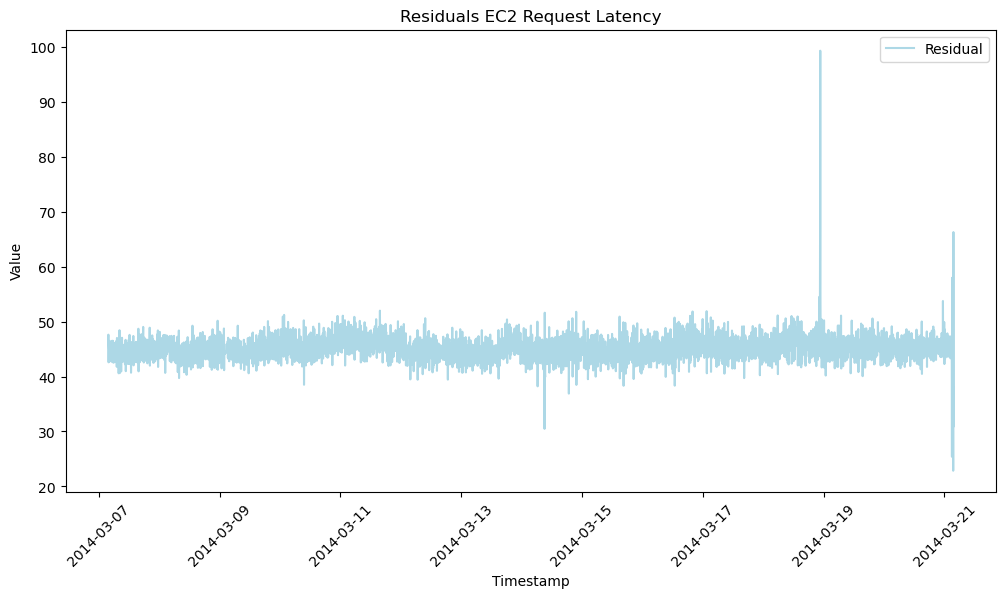

In [70]:
dftest = residuals.get('realKnownCause/ec2_request_latency_system_failure.csv')[0]
import matplotlib.pyplot as plt
import seaborn as sns

# Define colors for each anomaly type
color_map = {
    'Point': 'red'
}

plt.figure(figsize=(12, 6))

# Plot the entire dataset with a light gray line for reference
plt.plot(d['timestamp'], d['value'], color='lightblue', zorder=1, label='Residual')


plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.title("Residuals EC2 Request Latency")
plt.legend()
plt.xticks(rotation=45)
#plt.savefig('EC2_residuals.png')
plt.show()

# Plot the main time series
#plt.plot(dftest['timestamp'], dftest['residuals'], color='skyblue', label='Value', zorder=1)


realKnownCause/nyc_taxi.csv {'window_size': 48, 'anomaly_types': ['Unknown', 'Contextual', 'Contextual', 'Point', 'Point']}
['Unknown', 'Contextual', 'Contextual', 'Point', 'Point']
For anomaly type Unknown:
TP: 0, FP: 0, FN: 5, TN: 10315
Accuracy: 0.9995
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
For anomaly type Point:
TP: 1, FP: 264, FN: 4, TN: 10051
Accuracy: 0.9740
Precision: 0.0038
Recall: 0.2000
F1-Score: 0.0074
For anomaly type Contextual:
TP: 0, FP: 303, FN: 5, TN: 10012
Accuracy: 0.9702
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


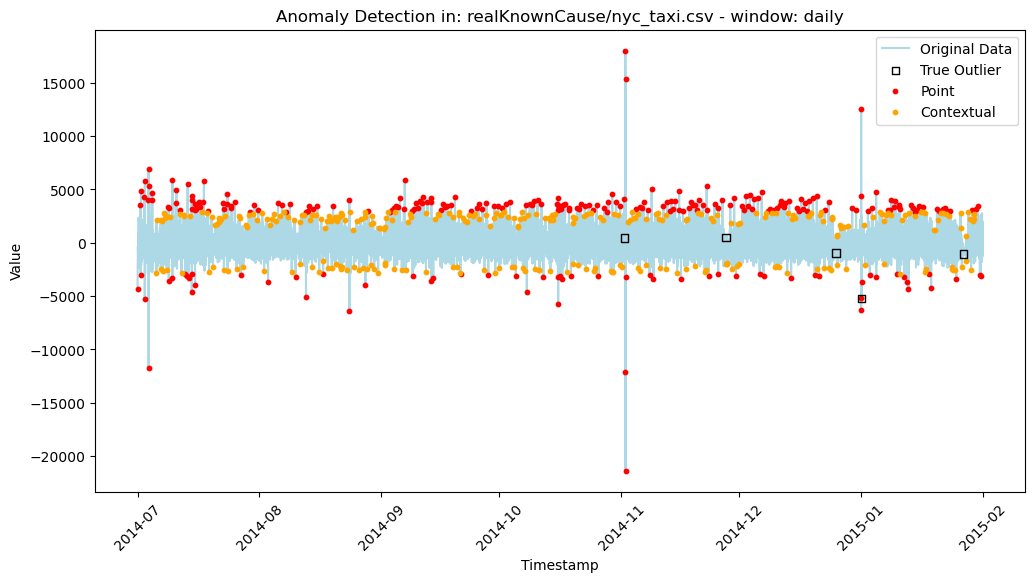

realKnownCause/nyc_taxi.csv {'window_size': 12, 'anomaly_types': ['Contextual', 'Contextual', 'Contextual', 'Point', 'Point']}
['Contextual', 'Contextual', 'Contextual', 'Point', 'Point']
For anomaly type Point:
TP: 1, FP: 264, FN: 4, TN: 10051
Accuracy: 0.9740
Precision: 0.0038
Recall: 0.2000
F1-Score: 0.0074
For anomaly type Contextual:
TP: 0, FP: 247, FN: 5, TN: 10068
Accuracy: 0.9756
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


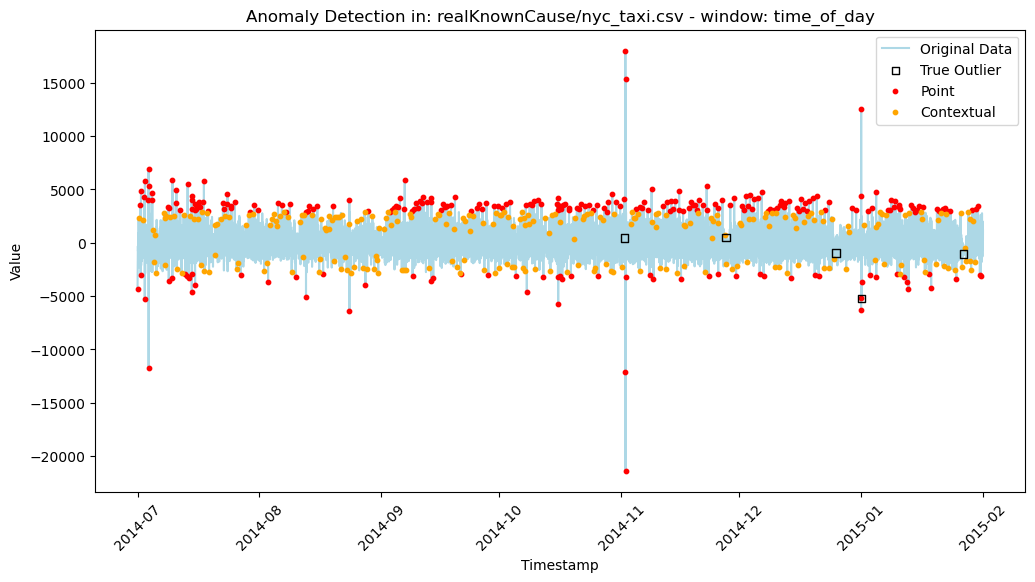

realKnownCause/rogue_agent_key_hold.csv {'window_size': 288, 'anomaly_types': ['Unknown', 'Unknown']}
['Unknown', 'Unknown']
For anomaly type Unknown:
TP: 0, FP: 0, FN: 2, TN: 5336
Accuracy: 0.9996
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


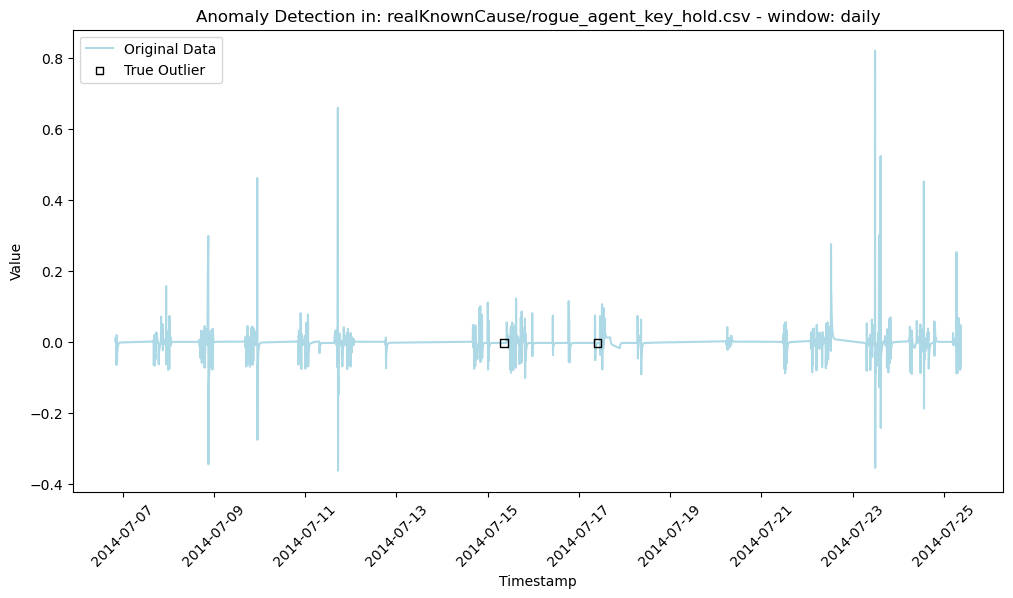

realKnownCause/rogue_agent_key_hold.csv {'window_size': 72, 'anomaly_types': ['Unknown', 'Unknown']}
['Unknown', 'Unknown']
For anomaly type Unknown:
TP: 0, FP: 0, FN: 2, TN: 5336
Accuracy: 0.9996
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


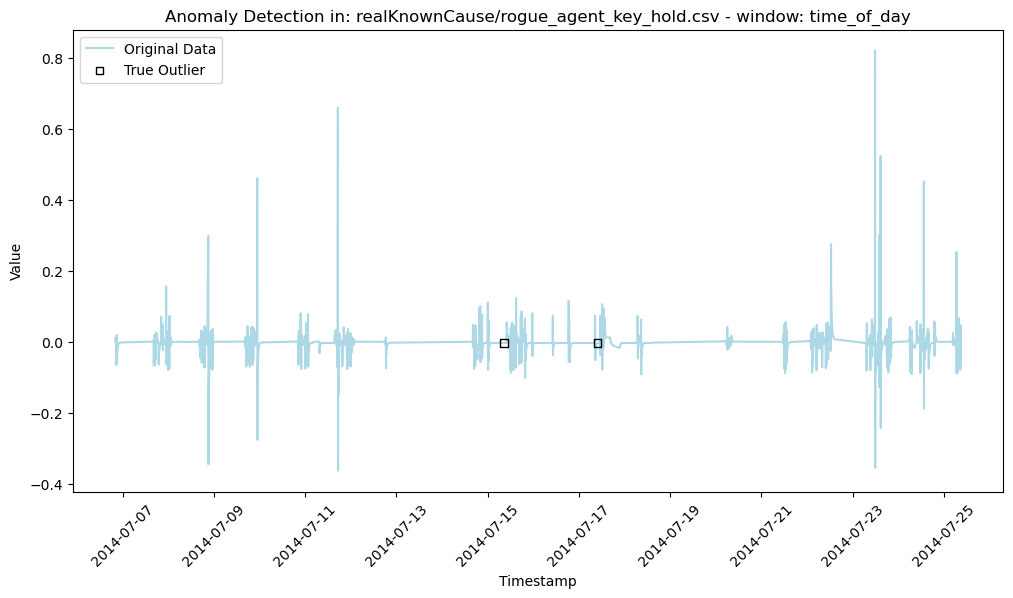

realKnownCause/cpu_utilization_asg_misconfiguration.csv {'window_size': 288, 'anomaly_types': ['Unknown', 'Unknown']}
['Unknown', 'Unknown']
For anomaly type Unknown:
TP: 0, FP: 0, FN: 2, TN: 18048
Accuracy: 0.9999
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


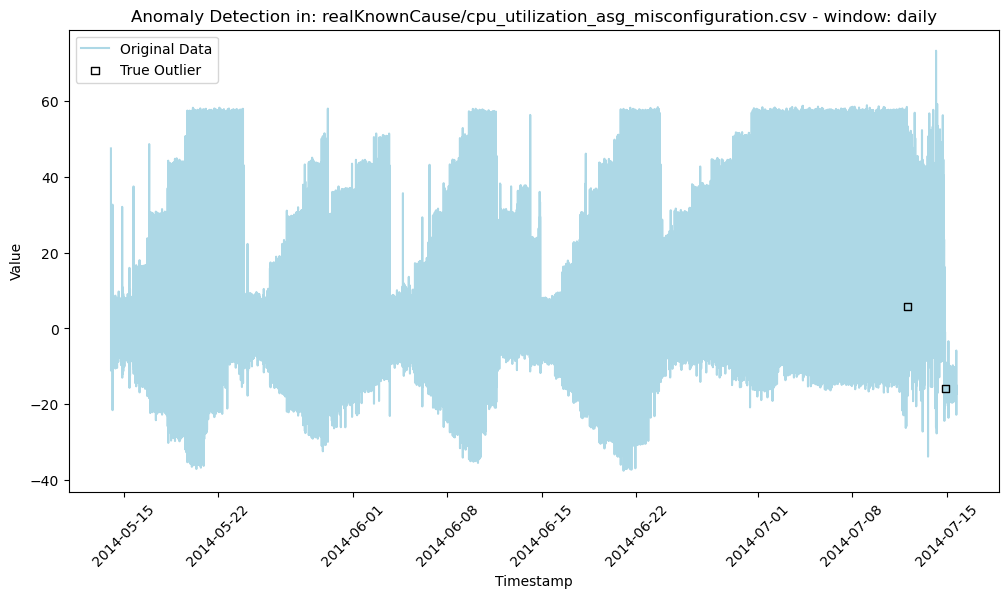

realKnownCause/cpu_utilization_asg_misconfiguration.csv {'window_size': 72, 'anomaly_types': ['Unknown', 'Unknown']}
['Unknown', 'Unknown']
For anomaly type Unknown:
TP: 0, FP: 0, FN: 2, TN: 18048
Accuracy: 0.9999
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


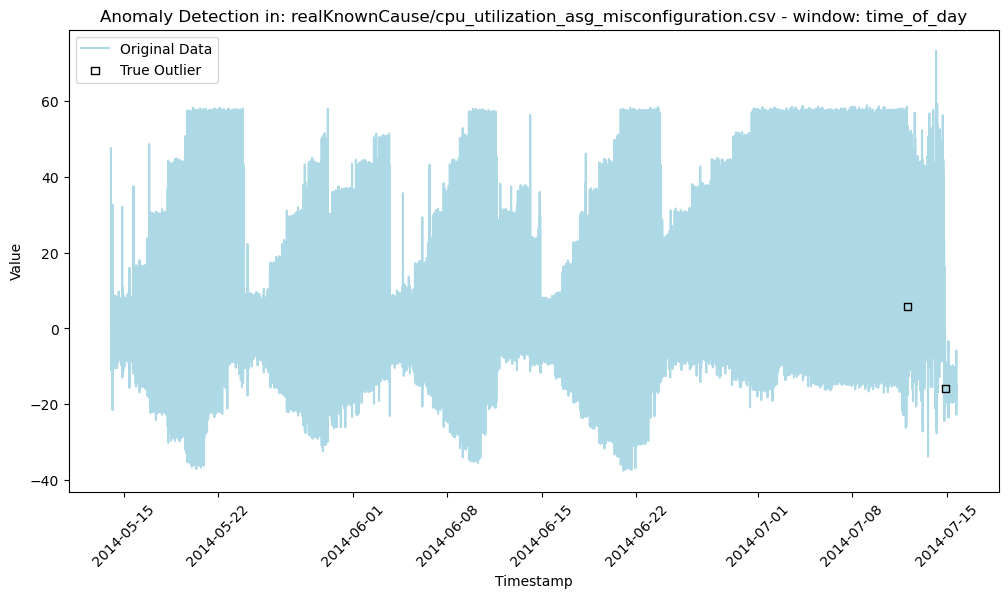

realKnownCause/rogue_agent_key_updown.csv {'window_size': 288, 'anomaly_types': ['Unknown', 'Unknown']}
['Unknown', 'Unknown']
For anomaly type Unknown:
TP: 0, FP: 0, FN: 2, TN: 5336
Accuracy: 0.9996
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


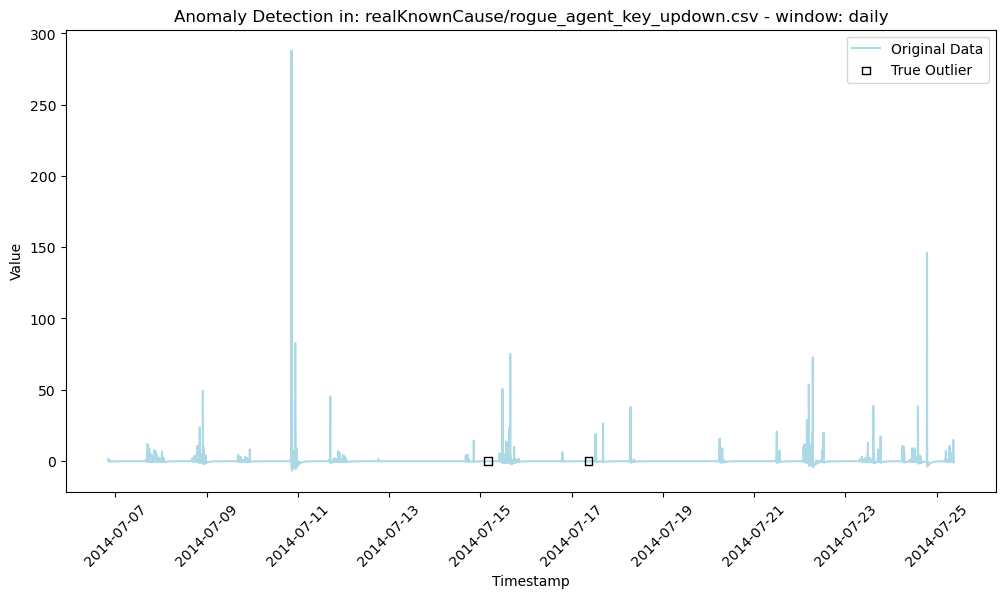

realKnownCause/rogue_agent_key_updown.csv {'window_size': 72, 'anomaly_types': ['Unknown', 'Unknown']}
['Unknown', 'Unknown']
For anomaly type Unknown:
TP: 0, FP: 0, FN: 2, TN: 5336
Accuracy: 0.9996
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


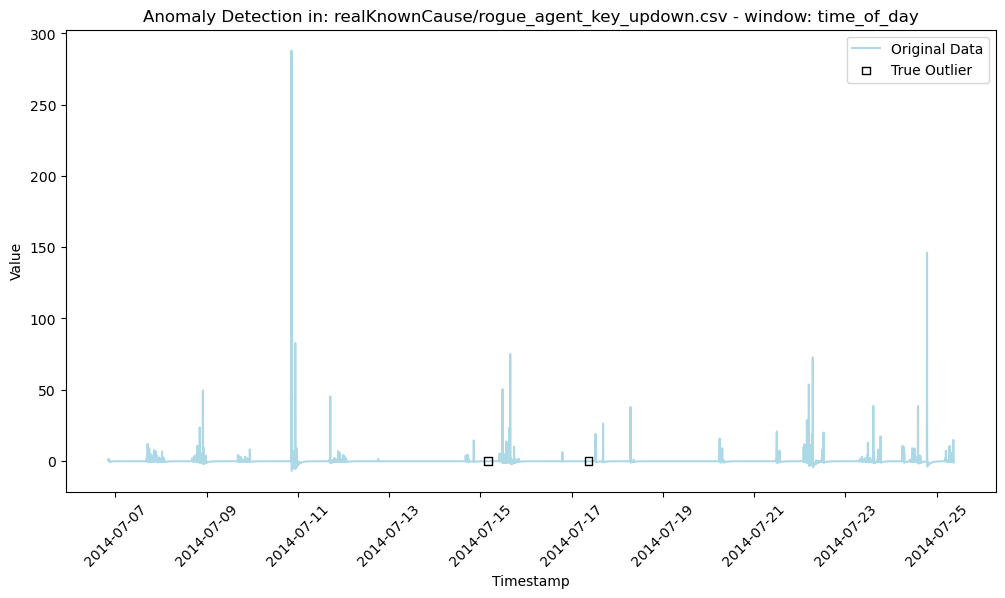

realKnownCause/ambient_temperature_system_failure.csv {'window_size': 24, 'anomaly_types': ['Point', 'Point']}
['Point', 'Point']
For anomaly type Point:
TP: 0, FP: 78, FN: 2, TN: 7808
Accuracy: 0.9899
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


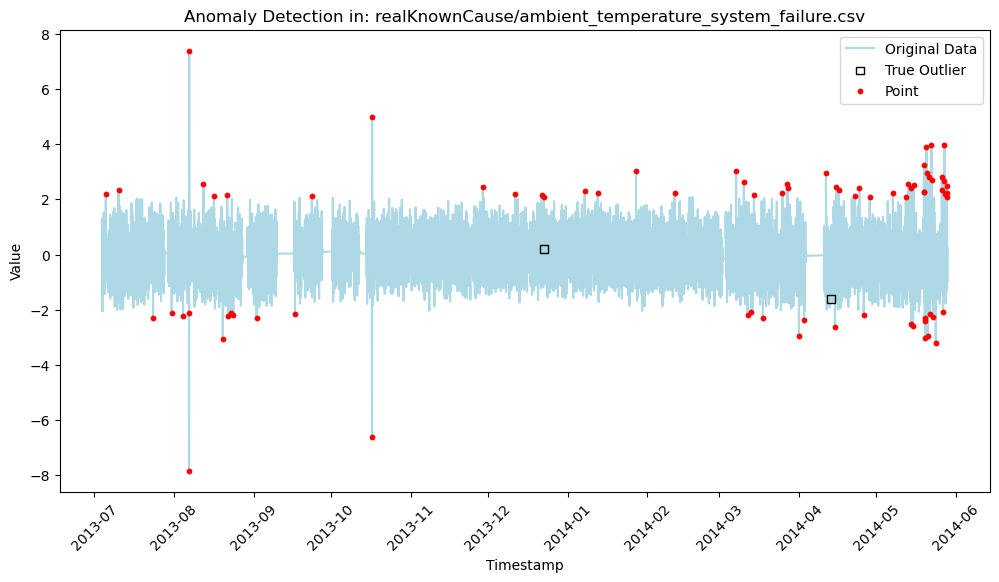

realKnownCause/ambient_temperature_system_failure.csv {'window_size': 6, 'anomaly_types': ['Point', 'Point']}
['Point', 'Point']
For anomaly type Point:
TP: 0, FP: 78, FN: 2, TN: 7808
Accuracy: 0.9899
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


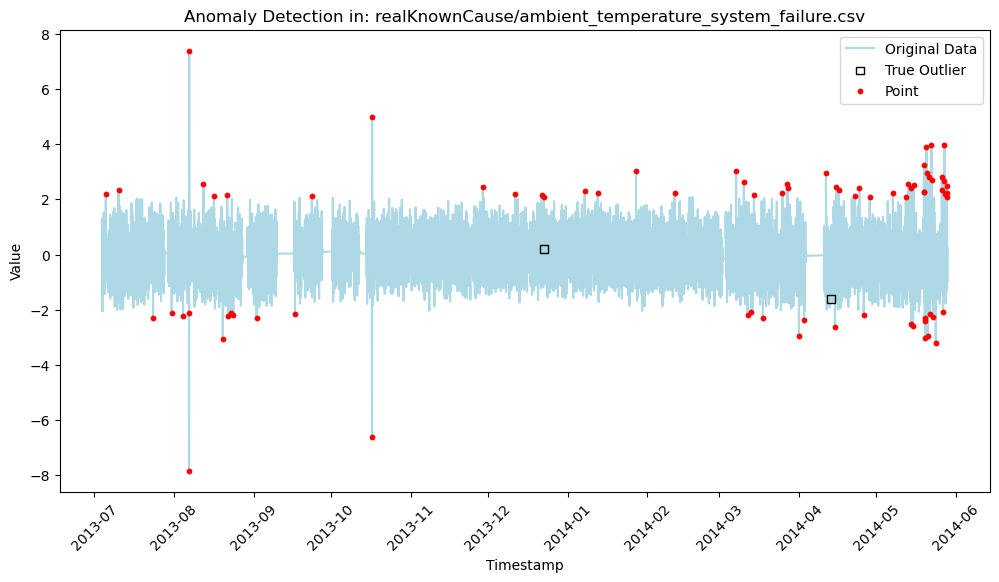

realKnownCause/machine_temperature_system_failure.csv {'window_size': 288, 'anomaly_types': ['Contextual', 'Point', 'Point', 'Point']}
['Contextual', 'Point', 'Point', 'Point']
For anomaly type Point:
TP: 0, FP: 179, FN: 4, TN: 22500
Accuracy: 0.9919
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
For anomaly type Contextual:
TP: 0, FP: 600, FN: 4, TN: 22079
Accuracy: 0.9734
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


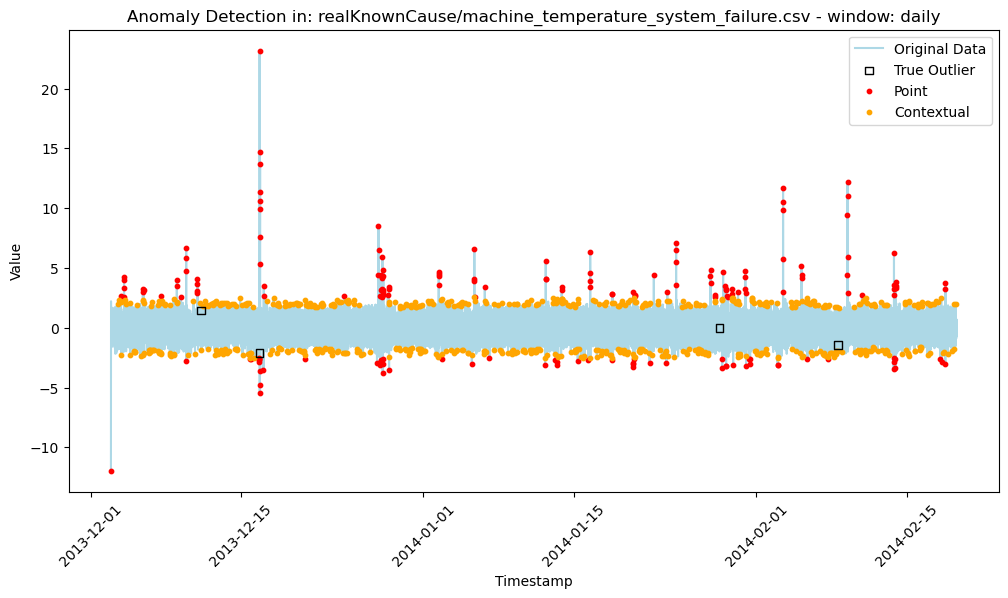

realKnownCause/machine_temperature_system_failure.csv {'window_size': 72, 'anomaly_types': ['Contextual', 'Point', 'Point', 'Point']}
['Contextual', 'Point', 'Point', 'Point']
For anomaly type Point:
TP: 0, FP: 179, FN: 4, TN: 22500
Accuracy: 0.9919
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
For anomaly type Contextual:
TP: 0, FP: 612, FN: 4, TN: 22067
Accuracy: 0.9728
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


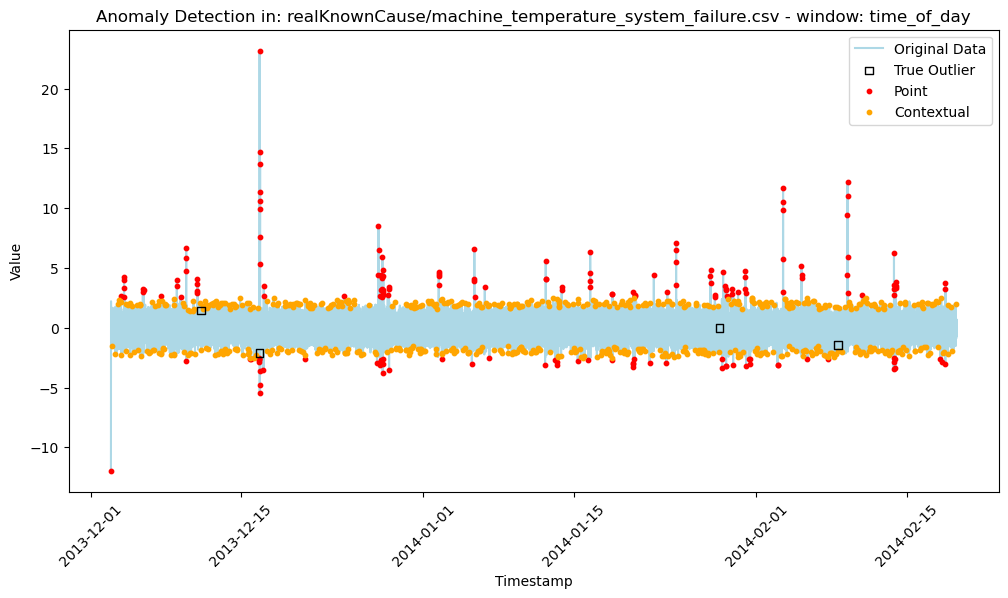

realKnownCause/ec2_request_latency_system_failure.csv {'window_size': 288, 'anomaly_types': ['Point', 'Point', 'Point']}
['Point', 'Point', 'Point']
For anomaly type Point:
TP: 3, FP: 27, FN: 0, TN: 4003
Accuracy: 0.9933
Precision: 0.1000
Recall: 1.0000
F1-Score: 0.1818


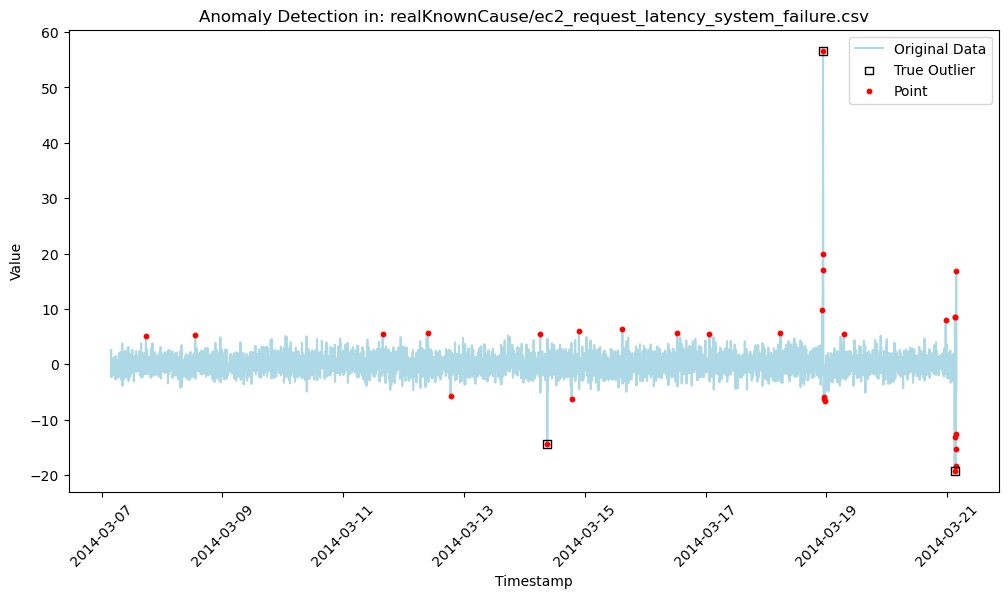

realKnownCause/ec2_request_latency_system_failure.csv {'window_size': 72, 'anomaly_types': ['Point', 'Point', 'Point']}
['Point', 'Point', 'Point']
For anomaly type Point:
TP: 3, FP: 27, FN: 0, TN: 4003
Accuracy: 0.9933
Precision: 0.1000
Recall: 1.0000
F1-Score: 0.1818


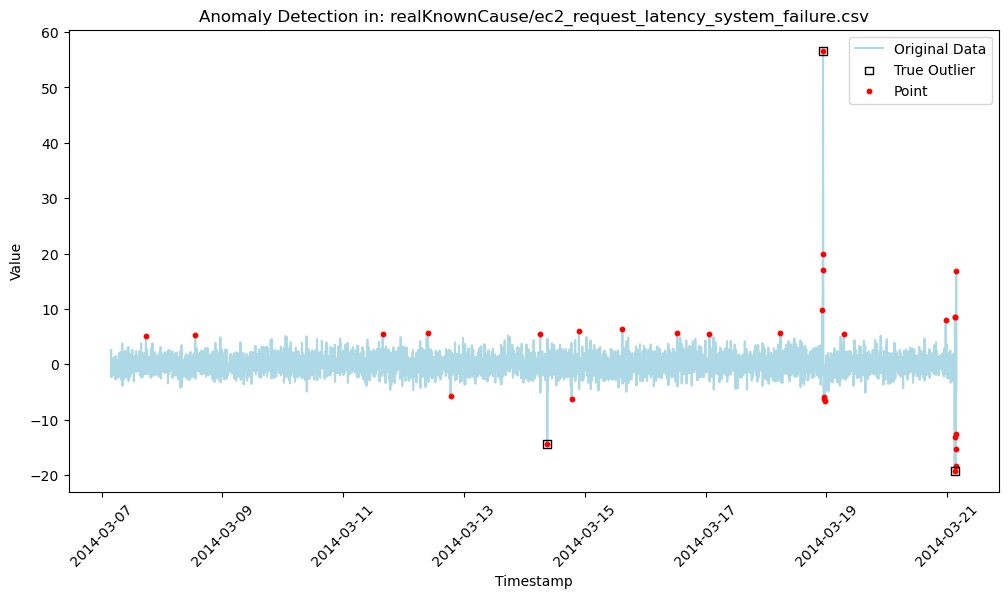

In [102]:
import numpy as np

# Load the cleaned JSON file
json_filename = 'outliers_type.json'
with open(json_filename, 'r') as json_file:
    data = json.load(json_file)

# Iterate over each file in the loaded JSON data
for filename, v in data.items():
    ranges = ['daily', 'time_of_day']
    column = 'residuals'
    
    # Iterate over daily and time_of_day ranges
    for r in ranges:
        vals = v.get(r)
        window_size = vals.get('window_size')
        anomaly_types = vals.get('anomaly_types')
        
        # Set the title based on anomaly types
        if set(anomaly_types) != {'Point'}:
            title = f'{filename} - window: {r}'
        else:
            title = f'{filename}'
        
        print(filename, v.get(r))
        print(anomaly_types)
        
        # Get the residuals data
        file_residuals = residuals.get(filename)[0].copy()
        
        # Apply outlier classification
        d = original_outlier_classify(file_residuals, column=column, window_size=window_size, z_thresh=2.5, context_limit=2, max_comparisons=4)
        
        # Loop through each anomaly type and calculate TP, FP, FN, TN
        for anomaly_type in set(anomaly_types):
            # Create a new column 'anomaly_type_col', which assigns 'anomaly_type' or 'Normal'
            d['anomaly_type_col'] = np.where(d['anomaly_type'] == anomaly_type, anomaly_type, 'Normal')
            #print(d[['anomaly_type', 'anomaly_type_col', 'outlier']].head(10)) 
            # Calculate TP, FP, FN, TN based on the new 'anomaly_type_col' and 'outlier'
            TP = np.sum((d['anomaly_type_col'] != 'Normal') & (d['outlier'] == 1))  # Predicted anomaly, actual anomaly
            FP = np.sum((d['anomaly_type_col'] != 'Normal') & (d['outlier'] == 0))  # Predicted anomaly, actual normal
            FN = np.sum((d['anomaly_type_col'] == 'Normal') & (d['outlier'] == 1))  # Predicted anomaly, actual normal
            TN = np.sum((d['anomaly_type_col'] == 'Normal') & (d['outlier'] == 0))  # Predicted normal, actual normal

            # Print out the results for the current anomaly type
            print(f'For anomaly type {anomaly_type}:')
            print(f'TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}')

            # Calculate Accuracy
            accuracy = (TP + TN) / (TP + FP + FN + TN)
            
            # Calculate Precision
            precision = TP / (TP + FP) if (TP + FP) != 0 else 0
            
            # Calculate Recall
            recall = TP / (TP + FN) if (TP + FN) != 0 else 0
            
            # Calculate F1 Score
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

            # Print the results
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1-Score: {f1:.4f}")
            
        # Plot detection results (this can remain unchanged)
        plot_detection(d, column, anomaly_types, title)
        #break
    #break


In [17]:
for preprocessed_df, residual, window_size in zip(preprocessed_dfs, residuals, window_sizes):
    df = preprocessed_df.copy()
    df['residual'] = residual
    window_size = window_size['first']
    df, result = outlier_combined(df, window_size)
    print(result)


[1, 14, 4, 10301]
[0, 84, 2, 5252]
[0, 364, 2, 17684]
[0, 68, 2, 5268]
[0, 10, 2, 7876]
[0, 270, 4, 22409]
[3, 73, 0, 3957]


# TimeGAN

In [9]:
from timegan_v2_18 import timegan 
from metrics.discriminative_score import discriminative_score_metrics
#from metrics.predictive_score import predictive_score_metrics

# Discrimnative and Predictive

In [7]:
# === Predictive
# Necessary Packages
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_absolute_error
from utils import extract_time
from tensorflow.keras.callbacks import EarlyStopping

 
def t_predictive_score_metrics(ori_data, generated_data):
    """Evaluate Post-hoc RNN one-step-ahead prediction.
    
    Args:
        - ori_data: Original time-series data
        - generated_data: Generated synthetic data
        
    Returns:
        - predictive_score: MAE of predictions on the original data
    """

    # Convert to NumPy arrays
    ori_data = np.asarray(ori_data, dtype=np.float32)
    generated_data = np.asarray(generated_data, dtype=np.float32)

    # Extract shape parameters
    no, seq_len, dim = ori_data.shape

    # Extract time sequences
    ori_time, ori_max_seq_len = extract_time(ori_data)
    generated_time, generated_max_seq_len = extract_time(generated_data)
    max_seq_len = max(ori_max_seq_len, generated_max_seq_len)

    # Model parameters
    hidden_dim = max(1, int(dim / 2))
    epochs = 50 #50  # Reduced iterations for TF2 efficiency
    batch_size = 128

    # Data preparation function
    def prepare_data(data, time):
        """Prepares input-output pairs for the predictor."""
        #X = np.array([d[:-1, :-1] for d in data])
        X = np.array([d[:-1, -1:] for d in data]) # keep only the last column
        T = np.array([t - 1 for t in time])
        #Y = np.array([np.reshape(d[1:, -1], (-1, 1)) for d in data])
        Y = np.array([d[1:, -1:] for d in data])  # Ensure Y aligns with X
        #print(f"X shape: {X.shape}")  # Should be (num_samples, seq_len, 1)
        #print(f"Y shape: {Y.shape}")  # Should be (num_samples, seq_len, 1)


        return X, T, Y

    # Prepare training data
    train_X, train_T, train_Y = prepare_data(generated_data, generated_time)
    
    # Define the Predictor model using Keras API
    class Predictor(tf.keras.Model):
        def __init__(self, hidden_dim):
            super(Predictor, self).__init__()
            self.rnn = tf.keras.layers.GRU(hidden_dim, activation='tanh', return_sequences=True)
            self.dense = tf.keras.layers.Dense(1, activation=None)

        def call(self, x):
            rnn_out = self.rnn(x)
            return tf.nn.sigmoid(self.dense(rnn_out))

    # Initialize the predictor model
    predictor = Predictor(hidden_dim)

    # Loss and Optimizer
    loss_fn = tf.keras.losses.MeanAbsoluteError()
    optimizer = tf.keras.optimizers.Adam(clipvalue=1.0)

    # Convert dataset into TensorFlow dataset API for efficiency
    train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
    #train_dataset = train_dataset.shuffle(len(train_X)).batch(batch_size)
    train_dataset = train_dataset.shuffle(len(train_X)).batch(batch_size, drop_remainder=True)

    # Early stopping setup
    early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

    # Training loop using GradientTape
    for epoch in range(epochs):
        if epoch % 50 == 0:
            print('Epoch: ', epoch)
        for X_batch, Y_batch in train_dataset:
            with tf.GradientTape() as tape:
                Y_pred = predictor(X_batch)
                loss = loss_fn(Y_batch, Y_pred)

            grads = tape.gradient(loss, predictor.trainable_variables)
            optimizer.apply_gradients(zip(grads, predictor.trainable_variables))
        
        # Early stopping check
        if early_stopping.stopped_epoch > 0:
            print(f"Early stopping triggered at epoch {early_stopping.stopped_epoch}")
            break

    # Prepare test data (on original dataset)
    test_X, test_T, test_Y = prepare_data(ori_data, ori_time)

    # Prediction on original data
    pred_Y = predictor(test_X).numpy()

    # Compute MAE
    mae_scores = [mean_absolute_error(test_Y[i], pred_Y[i]) for i in range(no)]
    predictive_score = np.mean(mae_scores)

    return predictive_score

2025-03-03 00:05:01.234504: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-03 00:05:01.256969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740953101.281082  508088 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740953101.288495  508088 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 00:05:01.314451: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
import time
import itertools
import numpy as np
import json 


# Define hyperparameters
hidden_dims = [10]#, 20, 50]
num_layers = [2]
modules = ['gru']#, 'lstm']

for window_size, preprocessed_df, file_name in zip(window_sizes, preprocessed_dfs, file_names):
    # Initialize dictionaries to store results
    model_stats = dict()  # Stores evaluation metrics
    model_stats[file_name] = {}
    
    if file_name != 'realKnownCause/ec2_request_latency_system_failure.csv':
        continue 
    print(f'Processing TimeGAN for {file_name}')
    name = file_name.split('/')[-1].split('.')[0] # example: realKnownCause/nyc_taxi.csv
    data = np.array(preprocessed_df['value']).reshape(-1, 1)
    # Initialize storage for this file
    

    for key, seq in window_size.items():
        print(f'--→Running for sequence length: {seq}')
        start = time.time()
        
        # Prepare time series sequences
        time_series = [data[i:i + seq] for i in range(len(data) - seq)]
        ori_data = np.array(time_series)

        # Iterate over all hyperparameter combinations
        parameters = {
            "hidden_dim": 24,
            "num_layer": 3,
            "iterations": 10000,
            "batch_size": 128,
            "module": 'gru'
        }
        
        # Train TimeGAN and generate synthetic data
        generated_data = timegan(ori_data, parameters)

        #print('Running discriminative traing...')
        # Calculate Discriminative Score (Close to 0.5 is better)
        metric_iteration = 5
        discriminative_scores = [
            discriminative_score_metrics(ori_data, generated_data) 
            for _ in range(metric_iteration)
        ]
        final_discri_score = np.round(np.mean(discriminative_scores), 4)
        print('Discriminative score: ', final_discri_score)
        print('Running Predictive training...')
        # Calculate Predictive Score (Lower is better)
        predictive_scores = [
            t_predictive_score_metrics(ori_data, generated_data) 
            for _ in range(metric_iteration)
        ]
        final_pred_score = np.round(np.mean(predictive_scores), 4)
        print('Predictive score: ', final_pred_score)
        # Store
        model_stats[file_name][key]= {
            'discriminative': float(final_discri_score),
            'predictive': float(final_pred_score)
        }
        # store logs
        store_name = f'{name}_seq_{key}'
    
        # Write the model_stats to a JSON file
        with open(f'timeganlogs/{store_name}.json', 'w') as json_file:
            json.dump(model_stats[file_name][key], json_file)
        with open(f'timeganlogs/{store_name}.txt', 'w') as file:
            file.write(str(final_discri_score))
            file.write(str(final_pred_score))
        print(f"Data written to {file_name}")

Processing TimeGAN for realKnownCause/nyc_taxi.csv
--→Running for sequence length: 48


I0000 00:00:1740953144.849485  508088 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0


Training completed


I0000 00:00:1740953183.787840  508420 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 0, D_loss: 0.6931
Epoch 0, D_loss: 0.6932
Epoch 0, D_loss: 0.6922
Epoch 0, D_loss: 0.6931
Epoch 0, D_loss: 0.6931
Discriminative score:  0.0026
Running Predictive training...
Epoch:  0


2025-03-03 00:08:07.551804: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-03 00:08:11.358703: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-03 00:08:18.931004: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


realKnownCause/nyc_taxi.csv, frequency = 6: [1, 5, 4, 10310]


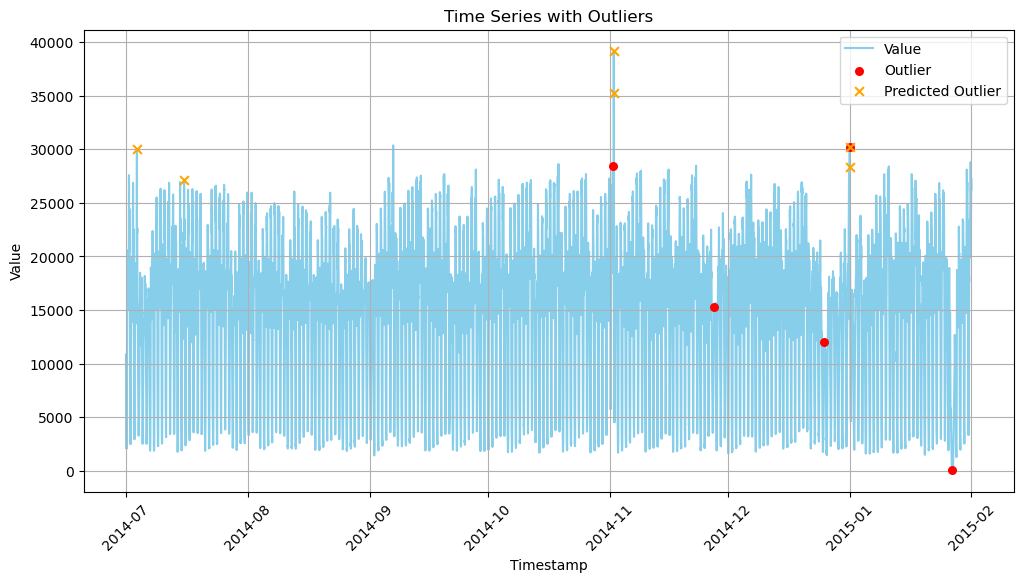

realKnownCause/nyc_taxi.csv, frequency = 48: [0, 9, 5, 10306]


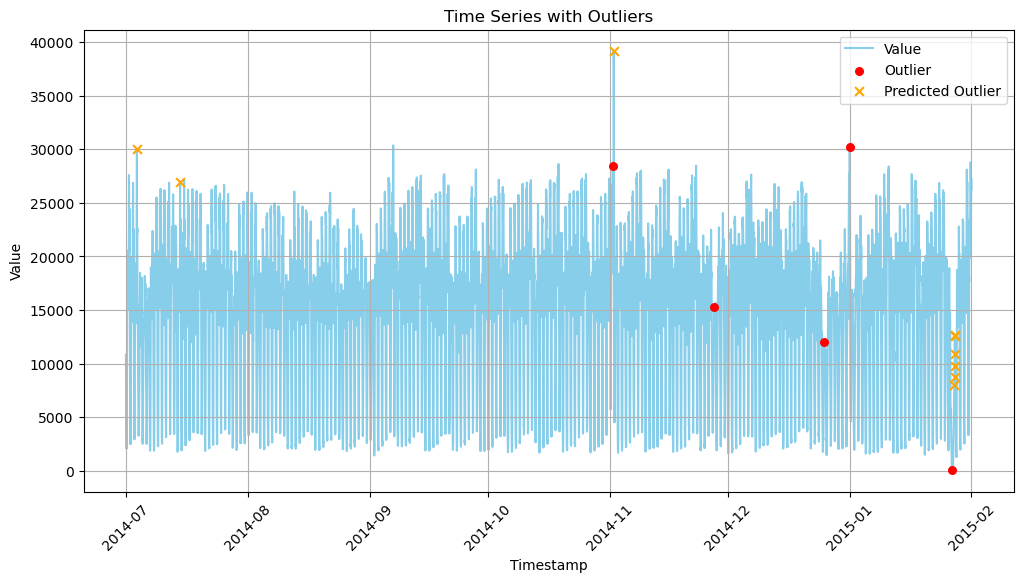



realKnownCause/rogue_agent_key_hold.csv, frequency = 12: [0, 14, 2, 5322]


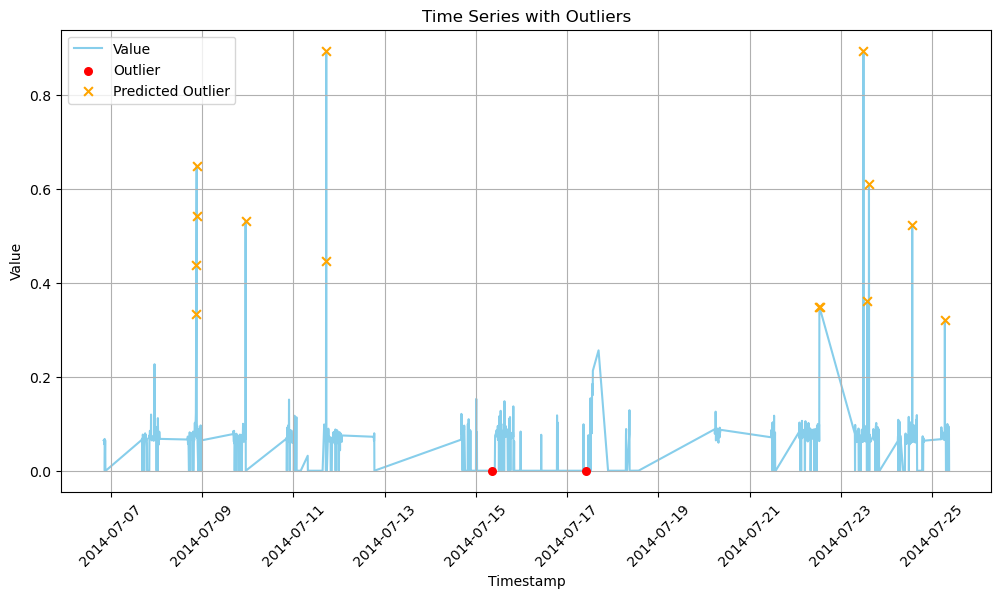

realKnownCause/rogue_agent_key_hold.csv, frequency = 288: [0, 69, 2, 5267]


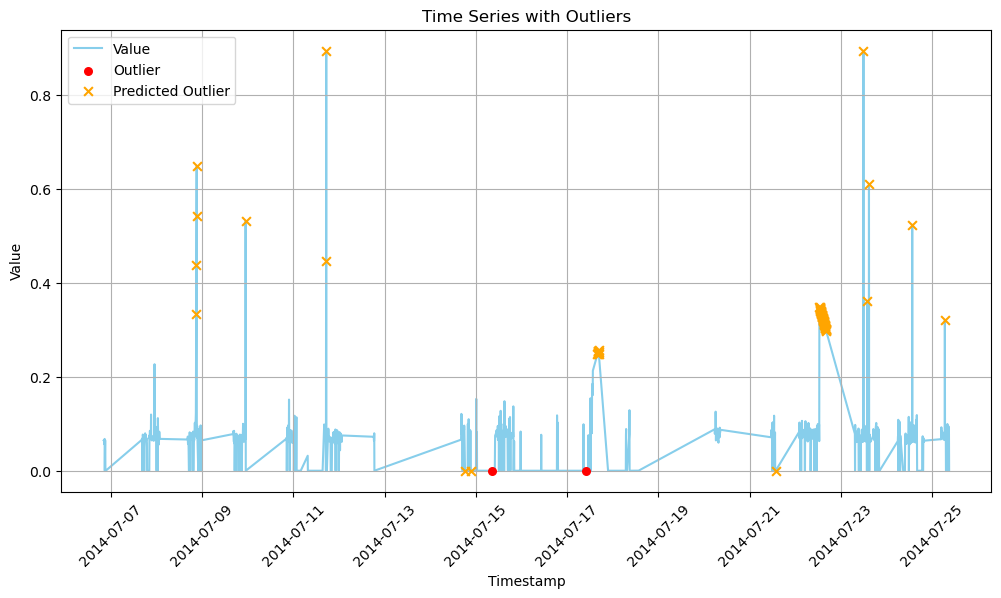



realKnownCause/cpu_utilization_asg_misconfiguration.csv, frequency = 12: [0, 40, 2, 18008]


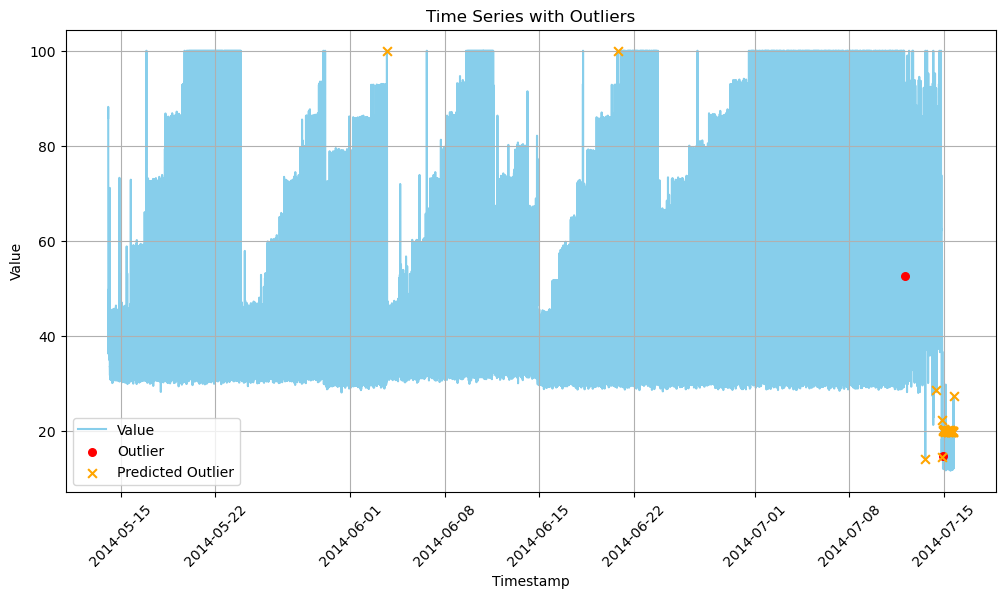

realKnownCause/cpu_utilization_asg_misconfiguration.csv, frequency = 288: [1, 242, 1, 17806]


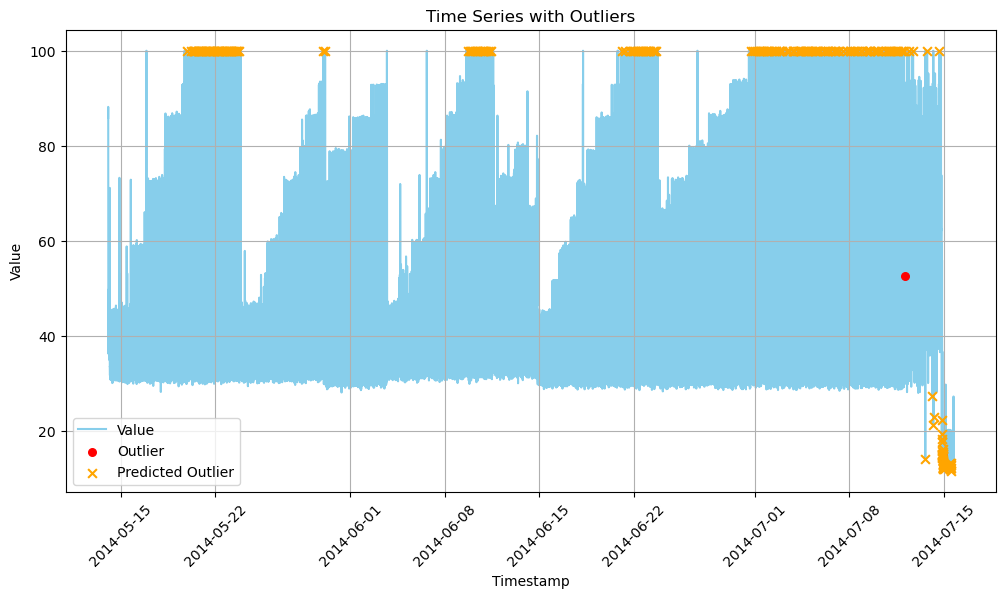



realKnownCause/rogue_agent_key_updown.csv, frequency = 12: [0, 99, 2, 5237]


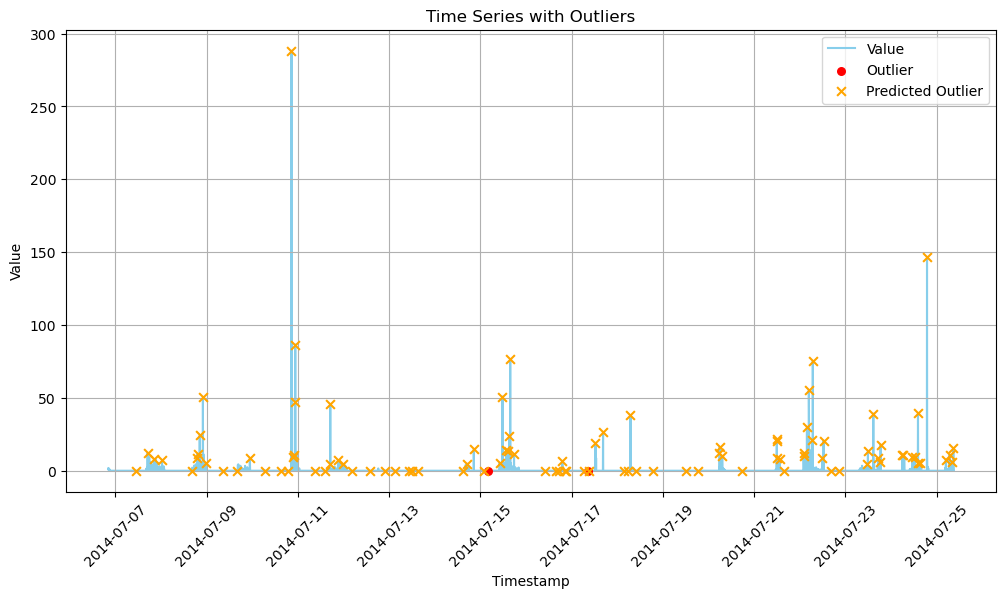

realKnownCause/rogue_agent_key_updown.csv, frequency = 288: [0, 72, 2, 5264]


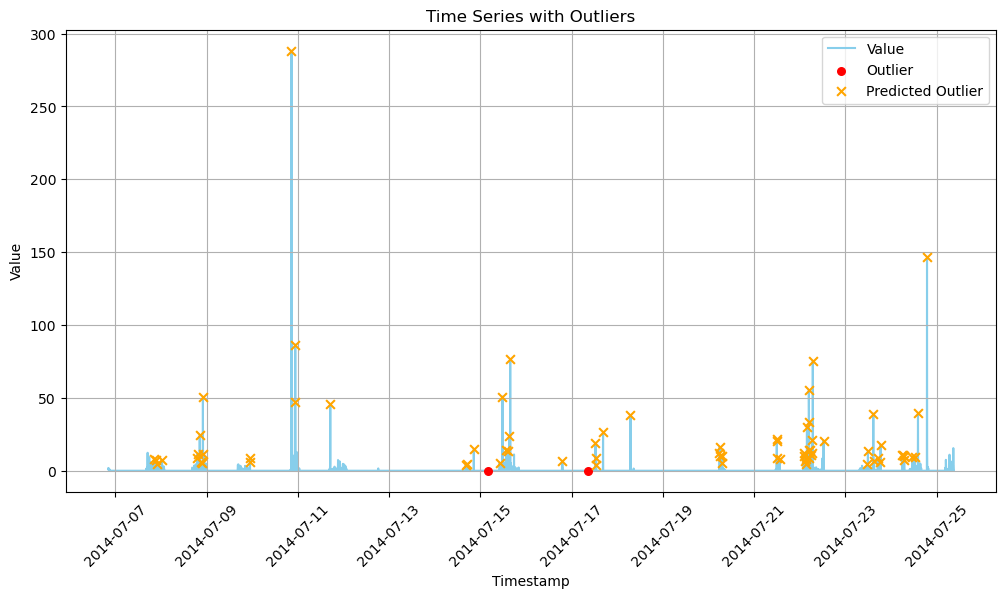



realKnownCause/ambient_temperature_system_failure.csv, frequency = 6: [1, 2, 1, 7884]


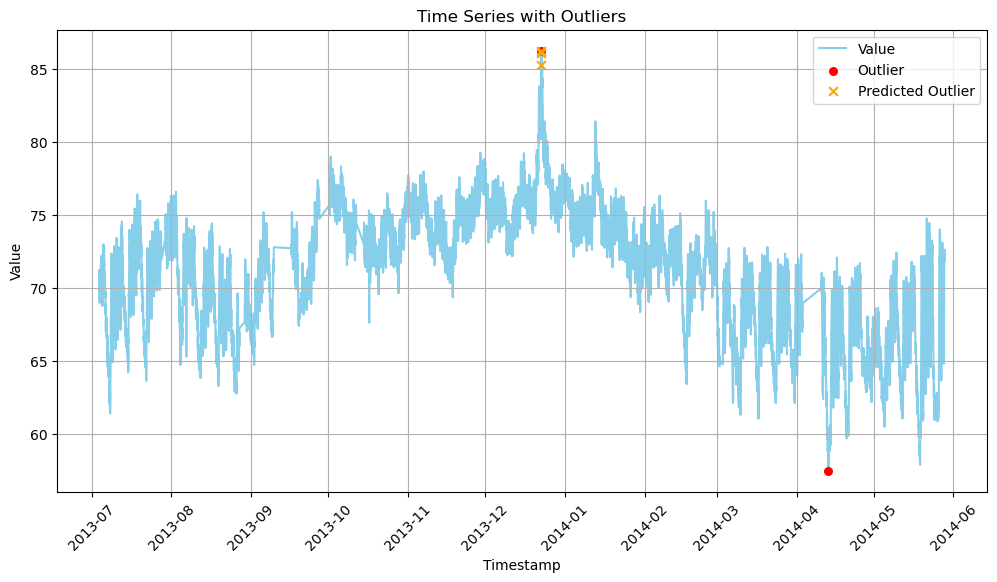

realKnownCause/ambient_temperature_system_failure.csv, frequency = 24: [1, 37, 1, 7849]


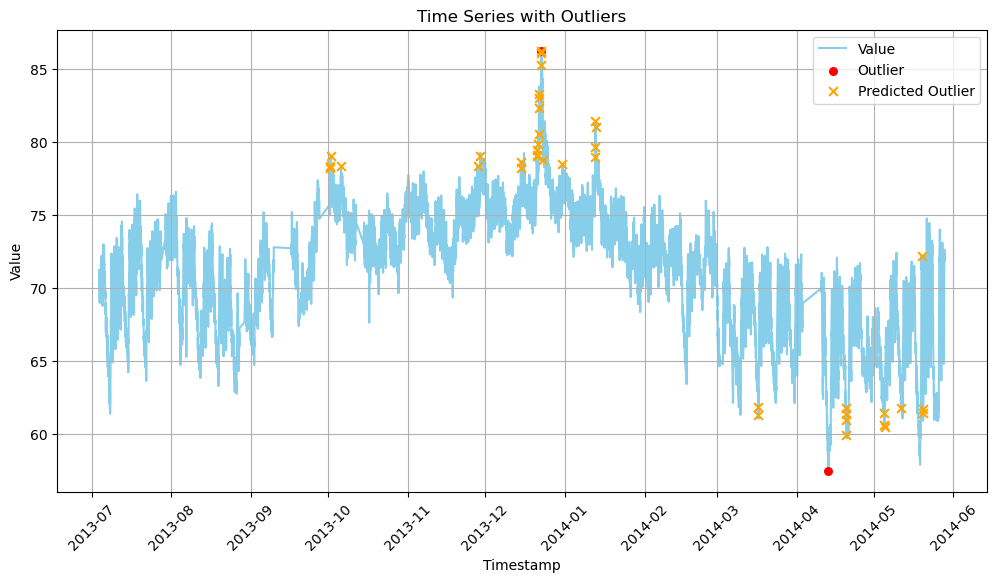



realKnownCause/machine_temperature_system_failure.csv, frequency = 12: [1, 58, 3, 22621]


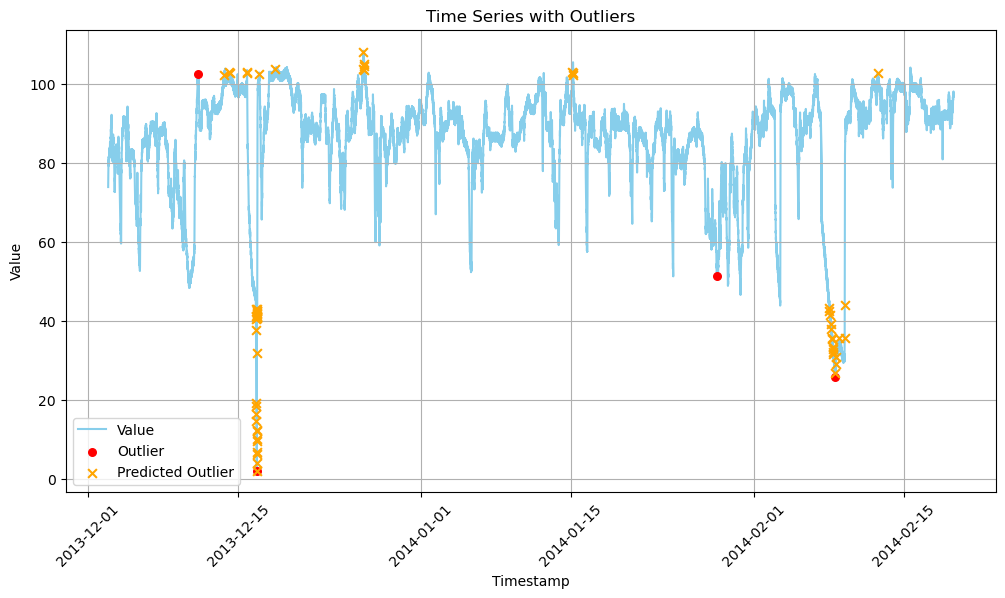

realKnownCause/machine_temperature_system_failure.csv, frequency = 288: [2, 112, 2, 22567]


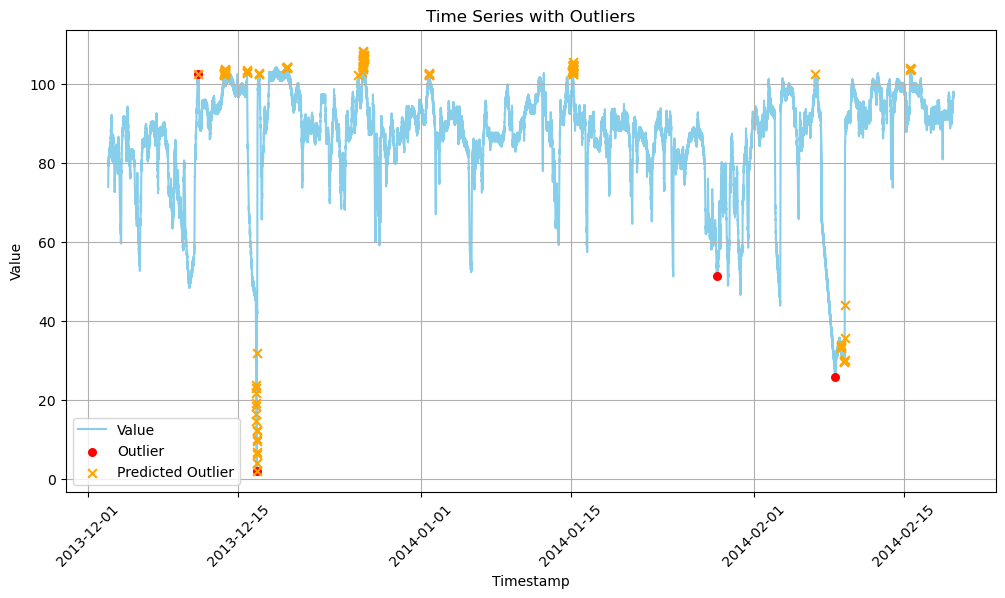



realKnownCause/ec2_request_latency_system_failure.csv, frequency = 12: [3, 69, 0, 3961]


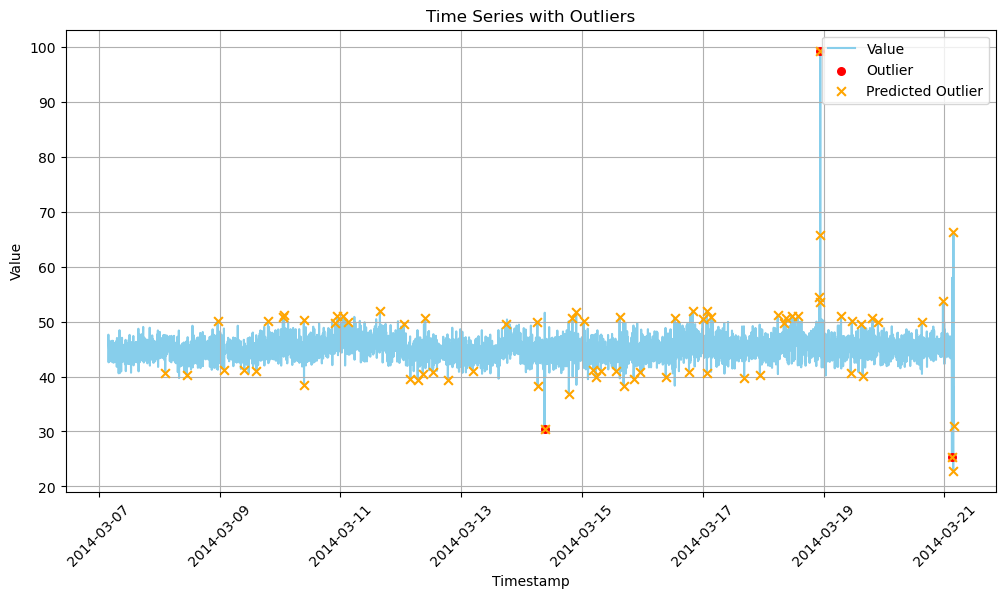

realKnownCause/ec2_request_latency_system_failure.csv, frequency = 288: [3, 122, 0, 3908]


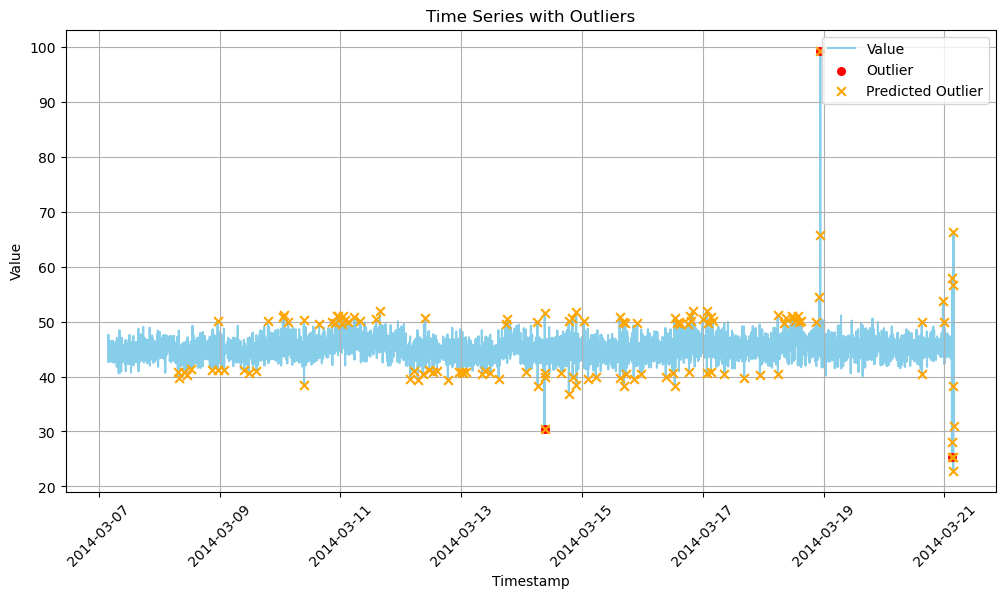

In [14]:
for window_size, preprocessed_df, file_name in zip(window_sizes, preprocessed_dfs, file_names):
    dfcopy = preprocessed_df.copy()
    freqs = window_size.values()
    for freq, generated_data in zip(freqs, timegan_dfs[file_name]):
        generated_values = np.array([seq[-1] for seq in generated_data]).flatten()
        dfcopy.loc[freq:, 'generated_values'] = generated_values
        dfcopy['generated_values'] = dfcopy['generated_values'].bfill() 
        dfcopy['residual'] = dfcopy['value'] - dfcopy['generated_values']
        df, result = outlier_combined(dfcopy, freq)
        print(f'{file_name}, frequency = {freq}: {result}')
        plot_detection(df)
    print('\n')

# ECOD

In [10]:
from pyod.models.ecod import ECOD

realKnownCause/nyc_taxi.csv, frequency = 6: [1, 8, 4, 10307]


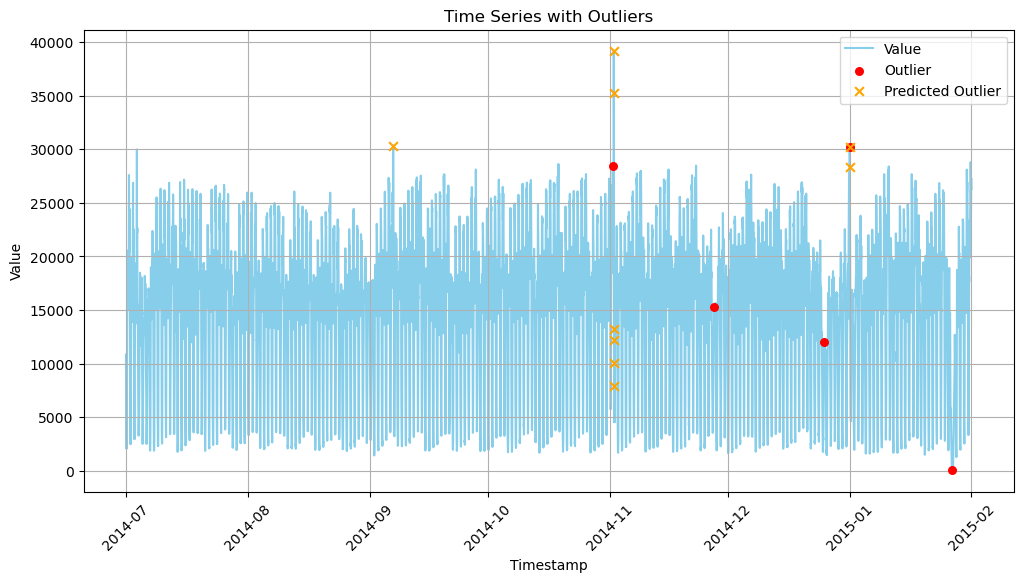

realKnownCause/nyc_taxi.csv, frequency = 48: [3, 83, 2, 10232]


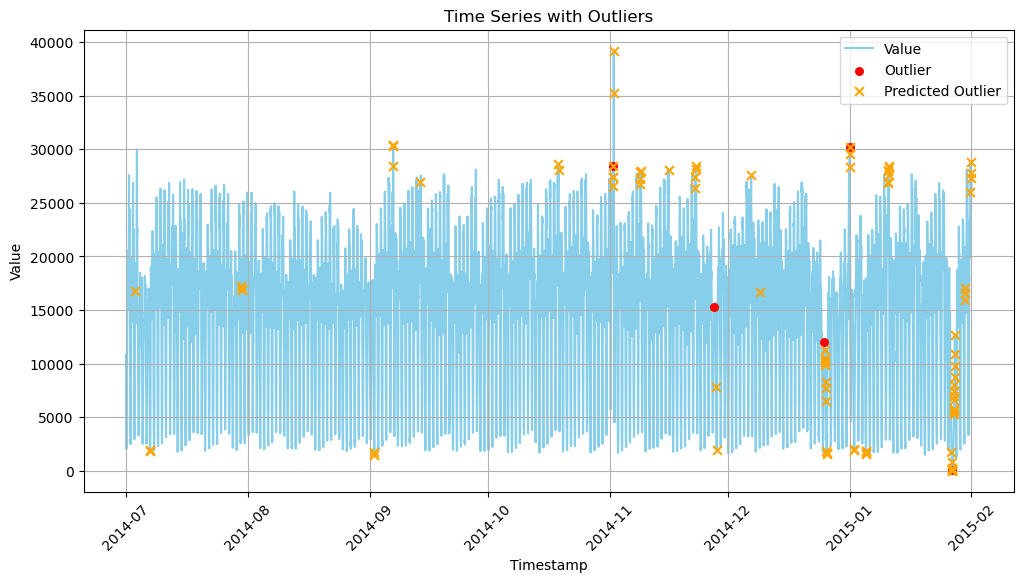



realKnownCause/rogue_agent_key_hold.csv, frequency = 12: [0, 24, 2, 5312]


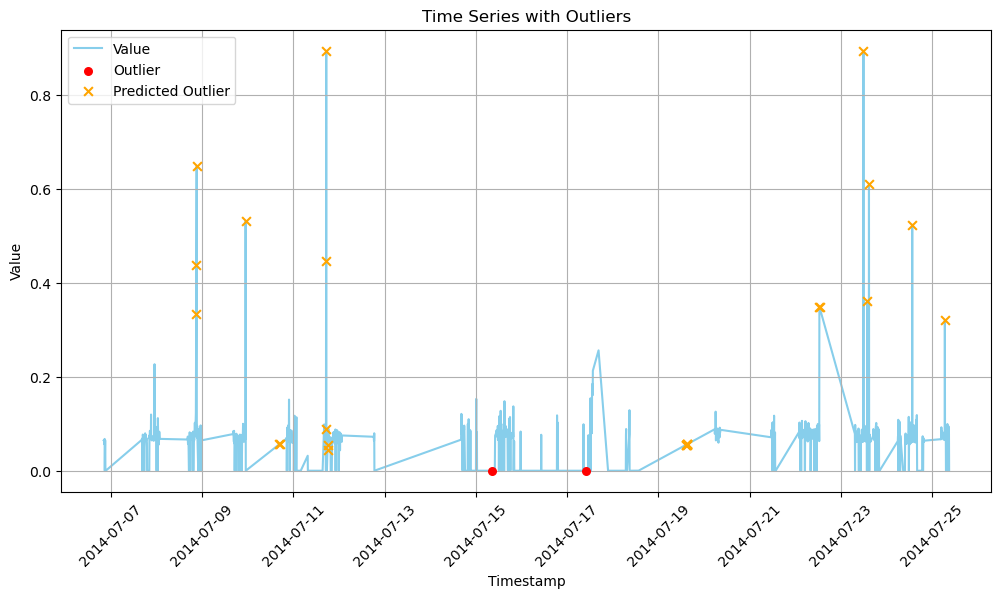

realKnownCause/rogue_agent_key_hold.csv, frequency = 288: [0, 58, 2, 5278]


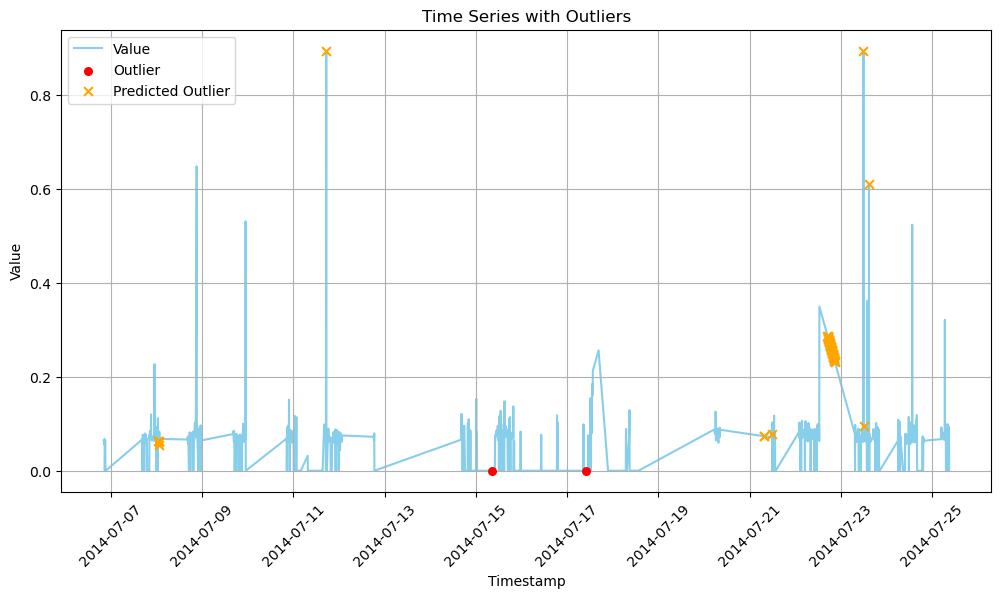



realKnownCause/cpu_utilization_asg_misconfiguration.csv, frequency = 12: [0, 52, 2, 17996]


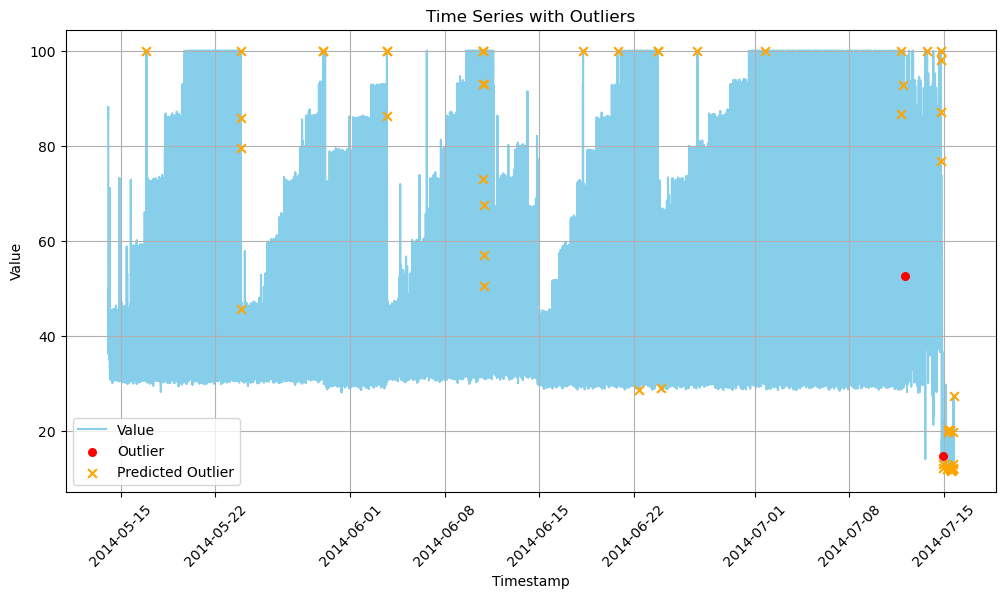

realKnownCause/cpu_utilization_asg_misconfiguration.csv, frequency = 288: [0, 162, 2, 17886]


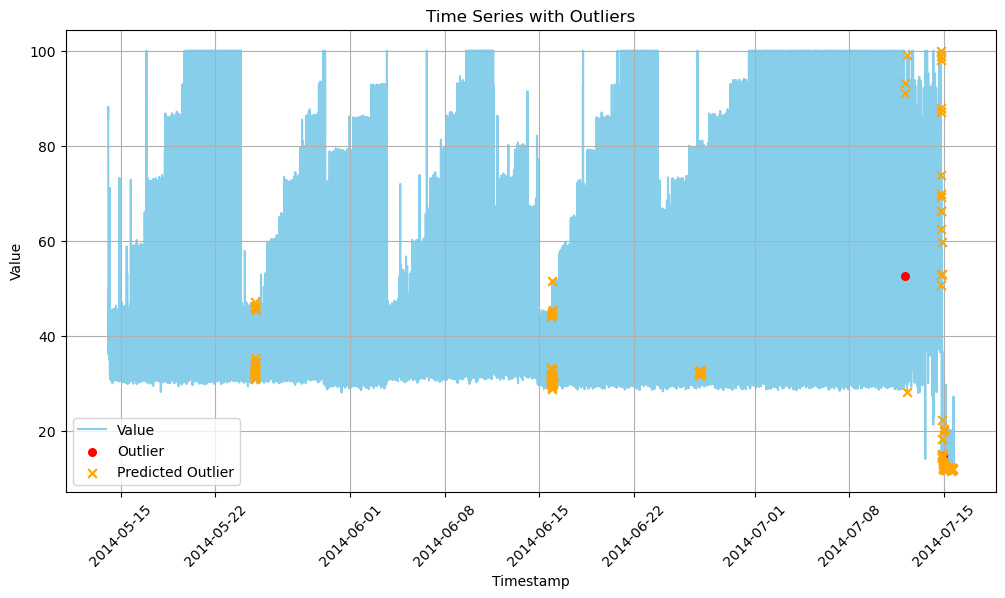



realKnownCause/rogue_agent_key_updown.csv, frequency = 12: [0, 28, 2, 5308]


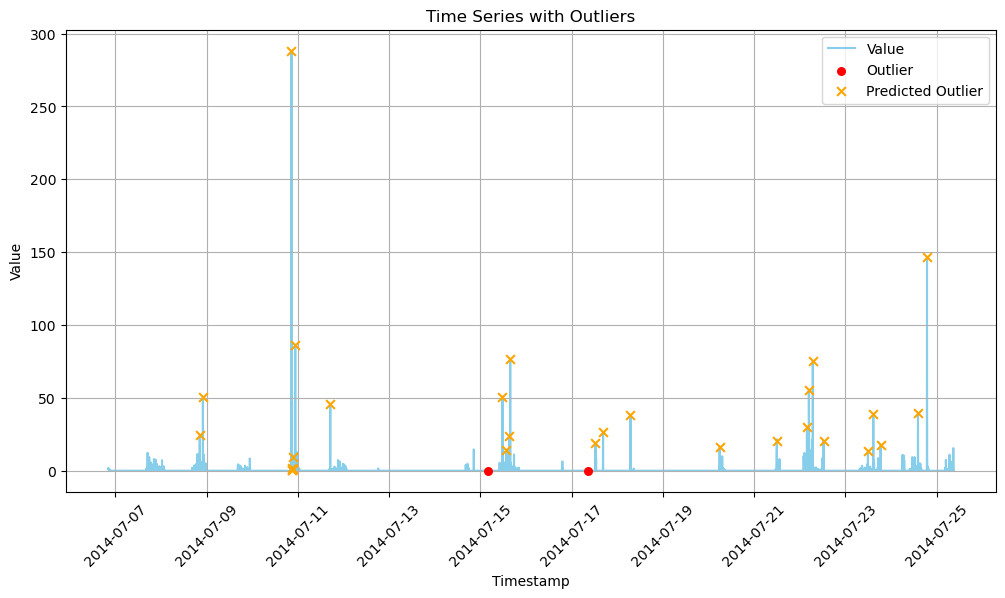

realKnownCause/rogue_agent_key_updown.csv, frequency = 288: [0, 86, 2, 5250]


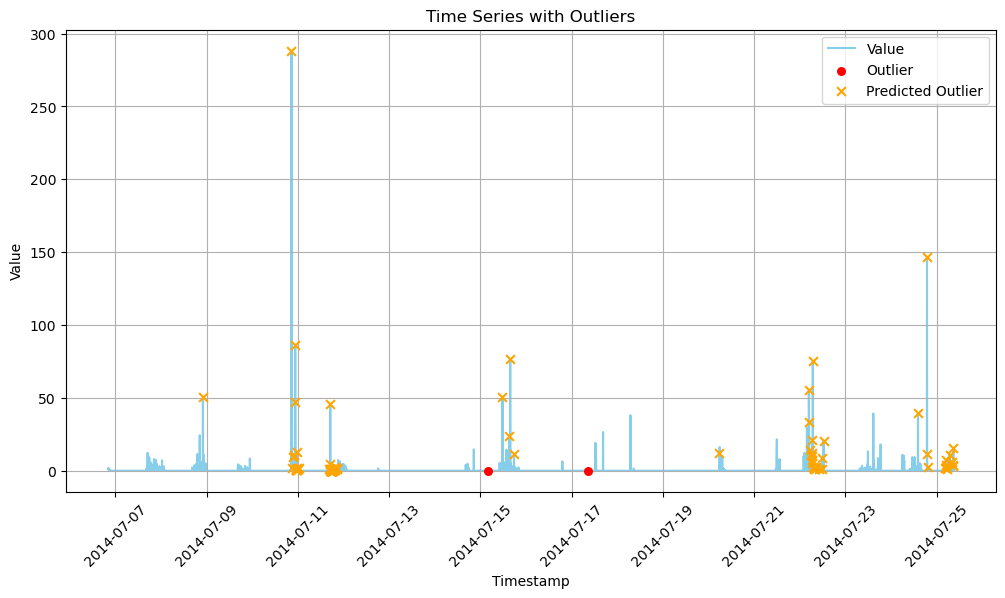



realKnownCause/ambient_temperature_system_failure.csv, frequency = 6: [1, 9, 1, 7877]


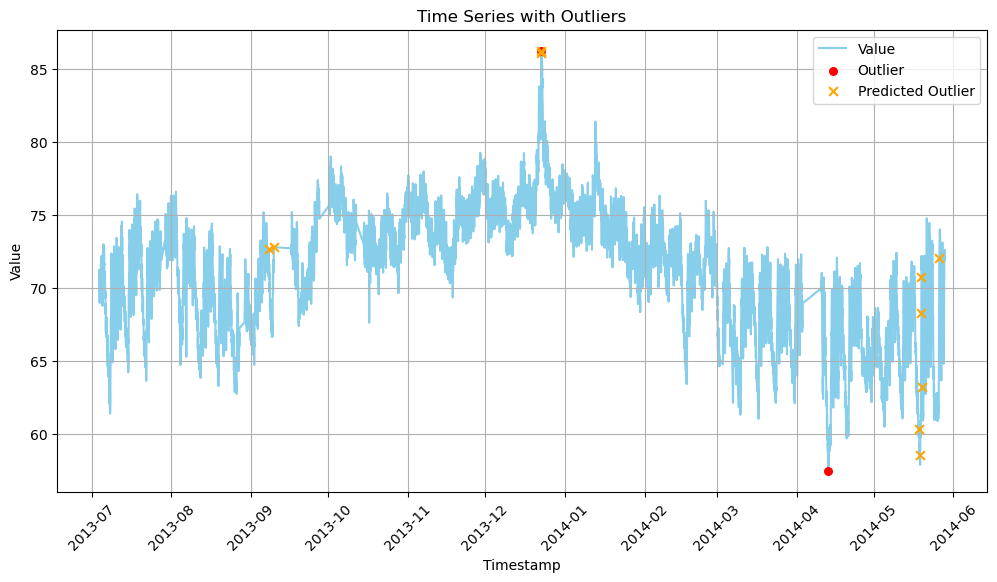

realKnownCause/ambient_temperature_system_failure.csv, frequency = 24: [2, 41, 0, 7845]


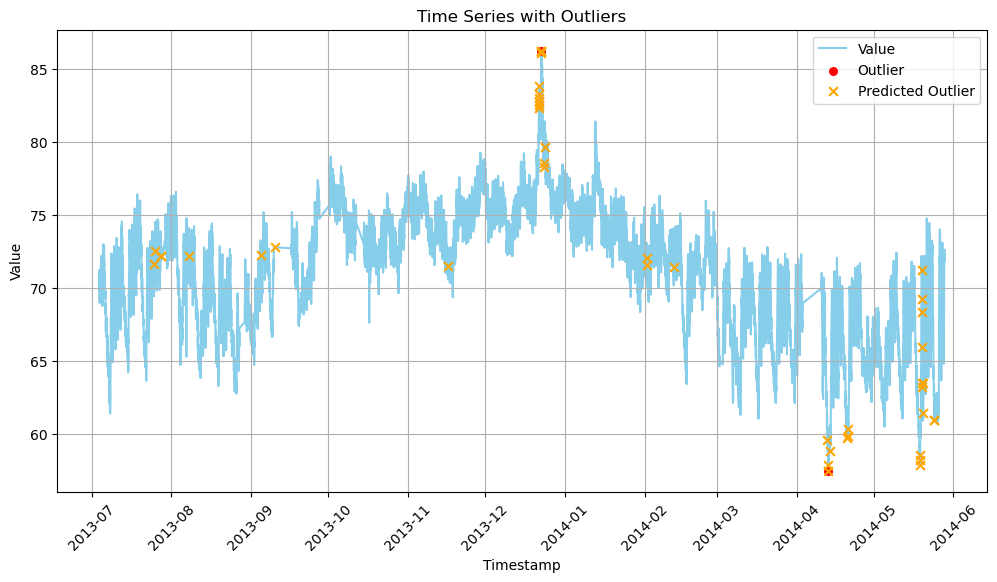



realKnownCause/machine_temperature_system_failure.csv, frequency = 12: [1, 115, 3, 22564]


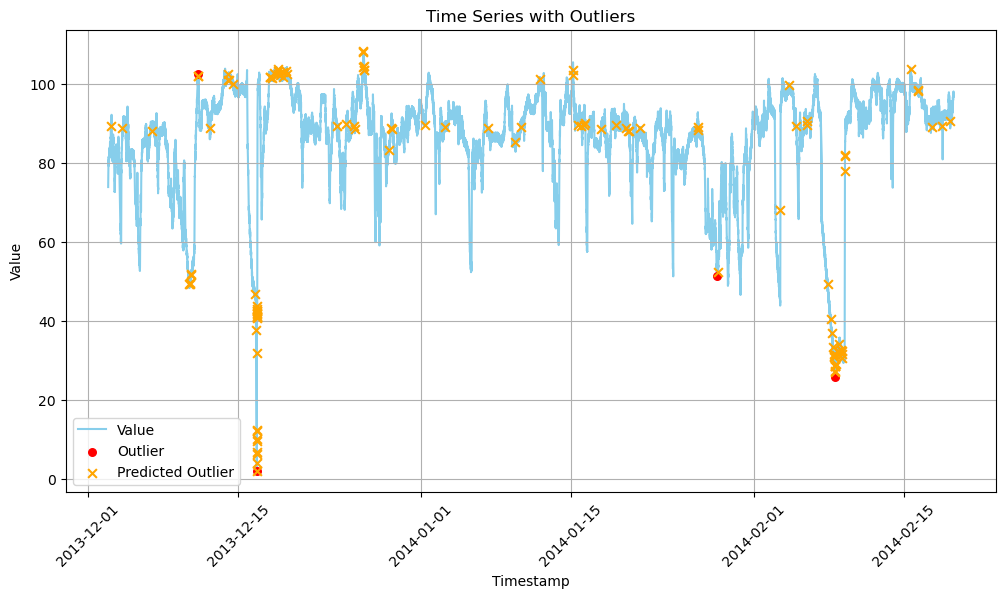

realKnownCause/machine_temperature_system_failure.csv, frequency = 288: [2, 178, 2, 22501]


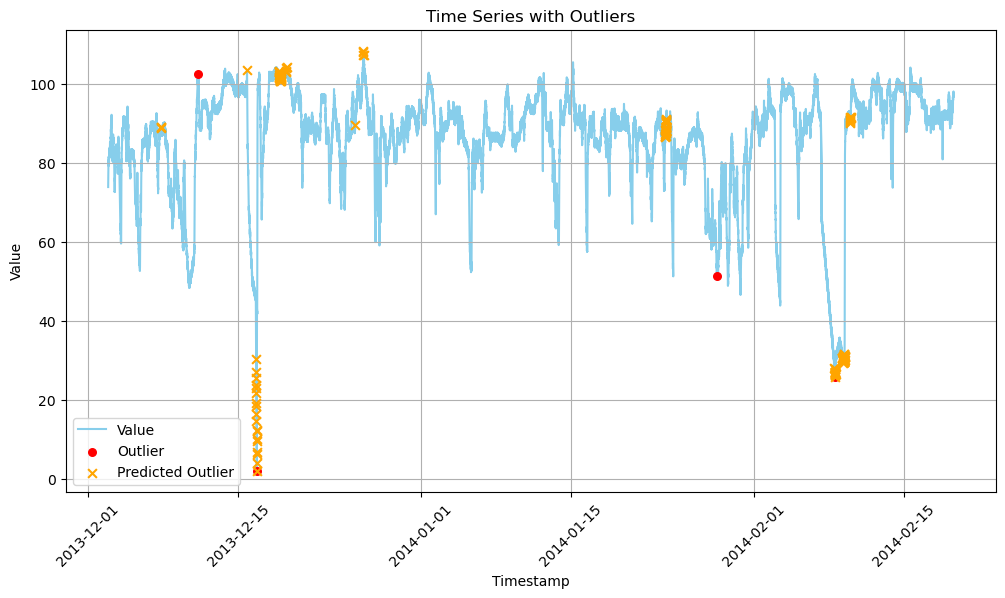



realKnownCause/ec2_request_latency_system_failure.csv, frequency = 12: [3, 39, 0, 3991]


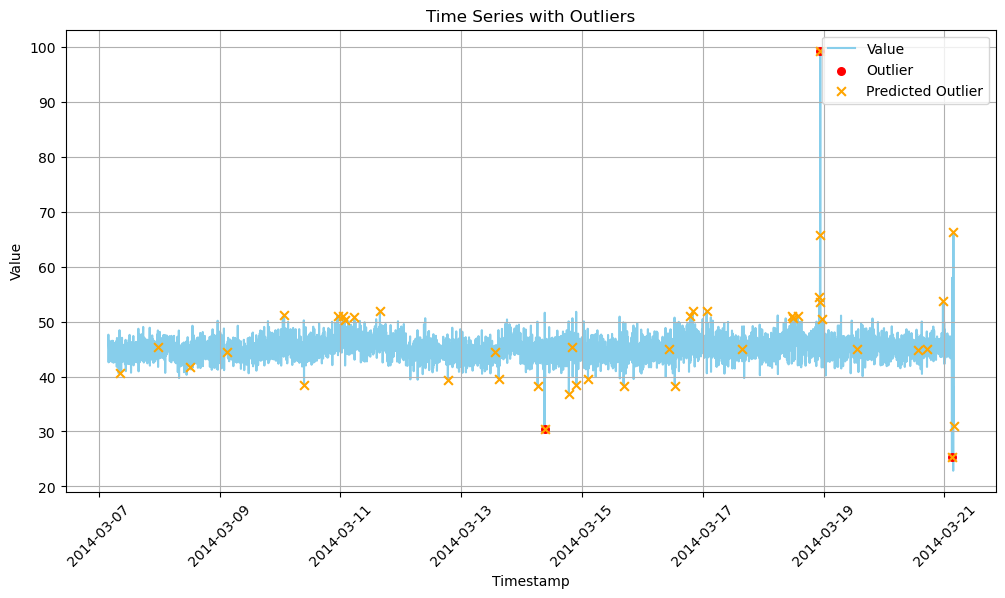

realKnownCause/ec2_request_latency_system_failure.csv, frequency = 288: [2, 72, 1, 3958]


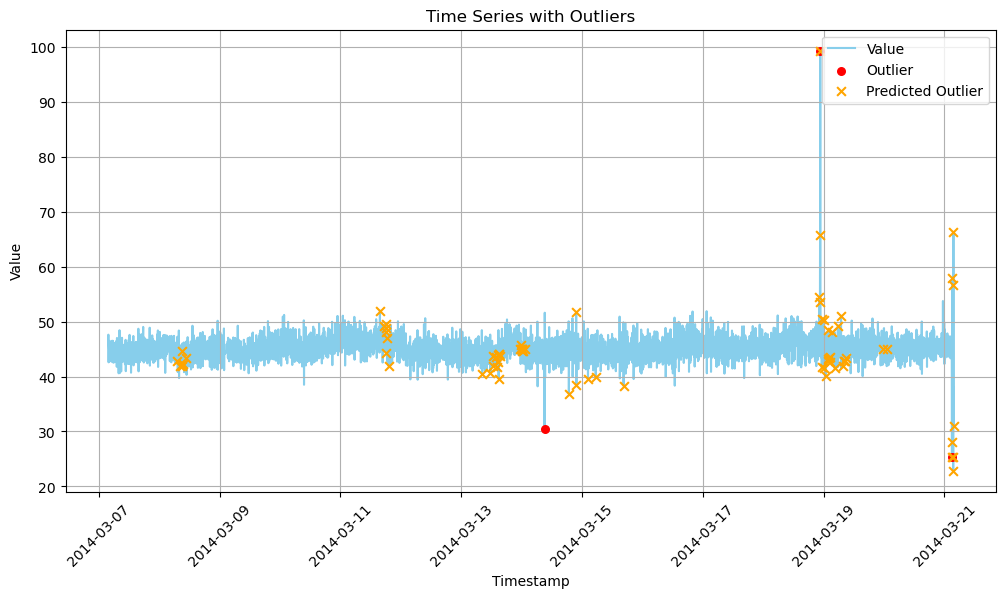

In [11]:
for window_size, preprocessed_df, file_name in zip(window_sizes, preprocessed_dfs, file_names):
    dfcopy = preprocessed_df.copy() 
    frequencies = window_size.values() 
    for freq in frequencies: 
        dfcopy['rolling_mean'] = dfcopy['value'].rolling(window=freq).mean().bfill()
        dfcopy['rolling_var'] = dfcopy['value'].rolling(window=freq).var().bfill()
        features = dfcopy[['value', 'rolling_mean', 'rolling_var']]

        # Step 1: Initialize the ECOD model
        ecod = ECOD()
        
        # Step 2: Fit the ECOD model on the entire dataset
        ecod.fit(features)
        
        # Step 3: Get outlier scores for the dataset
        outlier_scores = ecod.decision_function(features)
        dfcopy['residual'] = outlier_scores 
        df, result = outlier_combined(dfcopy, freq)
        print(f'{file_name}, frequency = {freq}: {result}')
        plot_detection(df)
    print('\n')
    

# TimeGAN + ECOD

In [32]:
for window_size, preprocessed_df, file_name in zip(window_sizes, preprocessed_dfs, file_names):
    dfcopy = preprocessed_df.copy()
    freqs = window_size.values()
    for freq, generated_data in zip(freqs, timegan_dfs[file_name]):
        generated_values = np.array([seq[-1] for seq in generated_data]).flatten()
        dfcopy.loc[freq:, 'generated_values'] = generated_values
        
        
        # add rolling statistics for ECOD 
        dfcopy['rolling_mean'] = dfcopy['value'].rolling(window=freq).mean().bfill()
        dfcopy['rolling_var'] = dfcopy['value'].rolling(window=freq).var().bfill()

        # replace original value with generated_value
        dfcopy['generated_values'] = dfcopy['generated_values'].bfill() 
        df['value'] = dfcopy['value'] - dfcopy['generated_values']

        features = dfcopy[['value', 'rolling_mean', 'rolling_var']]
        
        # Step 1: Initialize the ECOD model
        ecod = ECOD()
        
        # Step 2: Fit the ECOD model on the entire dataset
        ecod.fit(features)
        
        # Step 3: Get outlier scores for the dataset
        outlier_scores = ecod.decision_function(features)
        
        dfcopy['residual'] = outlier_scores 
        df, result = outlier_combined(dfcopy, freq)
        print(f'{file_name}, frequency = {freq}: {result}')
    print('\n')

realKnownCause/nyc_taxi.csv, frequency = 6: [1, 8, 4, 10307]
realKnownCause/nyc_taxi.csv, frequency = 48: [3, 83, 2, 10232]


realKnownCause/rogue_agent_key_hold.csv, frequency = 12: [0, 24, 2, 5312]
realKnownCause/rogue_agent_key_hold.csv, frequency = 288: [0, 59, 2, 5277]


realKnownCause/cpu_utilization_asg_misconfiguration.csv, frequency = 12: [0, 52, 2, 17996]
realKnownCause/cpu_utilization_asg_misconfiguration.csv, frequency = 288: [0, 178, 2, 17870]


realKnownCause/rogue_agent_key_updown.csv, frequency = 12: [0, 28, 2, 5308]
realKnownCause/rogue_agent_key_updown.csv, frequency = 288: [0, 112, 2, 5224]


realKnownCause/ambient_temperature_system_failure.csv, frequency = 6: [1, 9, 1, 7877]
realKnownCause/ambient_temperature_system_failure.csv, frequency = 24: [2, 41, 0, 7845]


realKnownCause/machine_temperature_system_failure.csv, frequency = 12: [1, 115, 3, 22564]
realKnownCause/machine_temperature_system_failure.csv, frequency = 288: [2, 181, 2, 22498]


realKnownCause/ec2_req